# 02 Pipeline de Treinamento

# 01. Setup Kaggle Dataset

In [1]:
!pip install opendatasets opencv-python-headless pandas pillow matplotlib seaborn torch torchvision --quiet
!pip install pyarrow fastparquet --quiet

import os
import opendatasets as od
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import subprocess
import glob
import csv
from copy import deepcopy
from getpass import getpass
from IPython.display import clear_output

BASE_DIR = "/content/clothing-coparsing-dataset"
DATASET_URL = "https://www.kaggle.com/datasets/balraj98/clothing-coparsing-dataset"

if not os.path.exists(BASE_DIR):
    print("Dataset não encontrado. Fazendo download do Kaggle...")
    print("IMPORTANTE: insira suas credenciais da API do Kaggle (kaggle.json).")
    od.download(DATASET_URL, data_dir="/content/")
    print(f"Dataset baixado em: {BASE_DIR}")
else:
    print(f"Dataset já disponível em: {BASE_DIR}")

IMAGES_DIR = os.path.join(BASE_DIR, "images")
LABELS_DIR = os.path.join(BASE_DIR, "labels/pixel_level_labels_colored")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 34.9 MB/s eta 0:00:00
Dataset não encontrado. Fazendo download do Kaggle...
IMPORTANTE: insira suas credenciais da API do Kaggle (kaggle.json).
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: raphaelmdecarvalho
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/balraj98/clothing-coparsing-dataset


100%|██████████| 134M/134M [00:00<00:00, 1.53GB/s]

Dataset baixado em: /content/clothing-coparsing-dataset


# 02. Carregar dataframe do GitHub
Se o repo é público, você pode usar o link bruto do GitHub:

In [2]:
PARQUET_URL = "https://github.com/RaphaelCarvalh/clothing-segmentation-project/raw/main/data/df_valido.parquet"
df_valido = pd.read_parquet(PARQUET_URL, engine="pyarrow")
print(f"Total válido carregado: {len(df_valido)} linhas")
df_valido.head()

Total válido carregado: 1003 linhas


,image_path_full,image_path_relative,label_path_full,label_path_relative,image_exists,label_exists,corrupted,image_hash,image_format,width,height,channels,is_duplicate,classes,num_classes,image_id
0,/content/clothing-coparsing-dataset/images/000...,images/0001.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0001.png,True,True,False,9349b423c4d40aea33b9334be15050ef,jpeg,550,832,3,False,"[hair, shoes, skin, blouse, skirt, stockings, ...",8,1
1,/content/clothing-coparsing-dataset/images/000...,images/0002.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0002.png,True,True,False,7d2824d0e04ca4fa0575fb88173a7cc1,jpeg,550,830,3,False,"[pumps, jacket, hair, dress, skin, socks]",6,2
2,/content/clothing-coparsing-dataset/images/000...,images/0003.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0003.png,True,True,False,b3671739ed055b6b2cb21bd12fab7627,jpeg,550,831,3,False,"[pants, purse, necklace, jacket, hair, dress, ...",13,3
3,/content/clothing-coparsing-dataset/images/000...,images/0004.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0004.png,True,True,False,886cfd5b1269d5c7d2566a202395ce4d,jpeg,550,810,3,False,"[pants, hat, shirt, glasses, shoes, coat, skin...",9,4
4,/content/clothing-coparsing-dataset/images/000...,images/0005.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0005.png,True,True,False,cb5c8591a2e29740db0601be07d80cc4,jpeg,550,842,3,False,"[purse, hair, shoes, dress, cape, skin, sungla...",8,5


Puxando o df com dados do dataset ja tratado Obs. Versão mais completa do import caso o repo fique privado em algum momento.

In [ ]:
# import getpass
# import pandas as pd
# import requests
# from io import StringIO

# # Pede token de forma segura
# GITHUB_TOKEN = getpass.getpass("Digite seu token GitHub: ")

# # URL do arquivo CSV
# CSV_PATH = "data/df_valido.csv"
# REPO = "RaphaelCarvalh/clothing-segmentation-project"
# RAW_URL = f"https://raw.githubusercontent.com/{REPO}/main/{CSV_PATH}"

# # Autenticação com token
# headers = {"Authorization": f"token {GITHUB_TOKEN}"}
# response = requests.get(RAW_URL, headers=headers)

# # Ler CSV na memória
# df_valido = pd.read_csv(StringIO(response.text))
# print(f"Total válido carregado: {len(df_valido)} linhas")
# df_valido.head()


# 03. Ajustar paths


In [3]:
def ajustar_paths(df):
    df_corrigido = df.copy()
    df_corrigido["image_path_full"] = df_corrigido["image_path_full"].apply(
        lambda x: os.path.join(IMAGES_DIR, os.path.basename(x)) if isinstance(x, str) else x
    )
    df_corrigido["label_path_full"] = df_corrigido["label_path_full"].apply(
        lambda x: os.path.join(LABELS_DIR, os.path.basename(x)) if isinstance(x, str) else x
    )
    return df_corrigido

df_valido = ajustar_paths(df_valido)
print("\nValidação dos caminhos após ajuste:")
print(f"Imagens encontradas: {df_valido['image_path_full'].apply(os.path.exists).sum()} / {len(df_valido)}")
print(f"Labels encontradas: {df_valido['label_path_full'].apply(os.path.exists).sum()} / {len(df_valido)}")

df_valido.head()


Validação dos caminhos após ajuste:
Imagens encontradas: 1003 / 1003
Labels encontradas: 1003 / 1003


,image_path_full,image_path_relative,label_path_full,label_path_relative,image_exists,label_exists,corrupted,image_hash,image_format,width,height,channels,is_duplicate,classes,num_classes,image_id
0,/content/clothing-coparsing-dataset/images/000...,images/0001.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0001.png,True,True,False,9349b423c4d40aea33b9334be15050ef,jpeg,550,832,3,False,"[hair, shoes, skin, blouse, skirt, stockings, ...",8,1
1,/content/clothing-coparsing-dataset/images/000...,images/0002.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0002.png,True,True,False,7d2824d0e04ca4fa0575fb88173a7cc1,jpeg,550,830,3,False,"[pumps, jacket, hair, dress, skin, socks]",6,2
2,/content/clothing-coparsing-dataset/images/000...,images/0003.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0003.png,True,True,False,b3671739ed055b6b2cb21bd12fab7627,jpeg,550,831,3,False,"[pants, purse, necklace, jacket, hair, dress, ...",13,3
3,/content/clothing-coparsing-dataset/images/000...,images/0004.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0004.png,True,True,False,886cfd5b1269d5c7d2566a202395ce4d,jpeg,550,810,3,False,"[pants, hat, shirt, glasses, shoes, coat, skin...",9,4
4,/content/clothing-coparsing-dataset/images/000...,images/0005.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0005.png,True,True,False,cb5c8591a2e29740db0601be07d80cc4,jpeg,550,842,3,False,"[purse, hair, shoes, dress, cape, skin, sungla...",8,5


# 05. Selecionar top 5 classes


In [4]:
import ast
from collections import Counter

# Converter a coluna 'classes' (que está como string) para lista real
if isinstance(df_valido.iloc[0]["classes"], str):
    df_valido["classes"] = df_valido["classes"].apply(ast.literal_eval)

# Contar frequência total de todas as classes
all_classes = [cls for sublist in df_valido["classes"] for cls in sublist]
class_counts = Counter(all_classes)

# Mostrar as 10 classes mais frequentes
print(" Classes mais frequentes:")
for cls, count in class_counts.most_common(10):
    print(f"{cls}: {count}")

# Selecionar apenas as 5 classes mais comuns
top_classes = [cls for cls, _ in class_counts.most_common(5)]
print(f"\n Mantendo apenas as 5 classes mais comuns: {top_classes}")

# Filtrar o dataframe para manter apenas imagens que contenham pelo menos uma dessas classes
df_filtrado = df_valido[df_valido["classes"].apply(lambda cls_list: any(c in top_classes for c in cls_list))].reset_index(drop=True)

print(f" Total de imagens após filtro: {len(df_filtrado)} (de {len(df_valido)} originais)")
print(f" Proporção entre : {len(df_filtrado) / len(df_valido) * 100:.2f}%")

 Classes mais frequentes:
skin: 1002
hair: 959
shoes: 774
bag: 443
pants: 302
sunglasses: 293
dress: 270
purse: 234
coat: 232
accessories: 223

 Mantendo apenas as 5 classes mais comuns: ['skin', 'hair', 'shoes', 'bag', 'pants']
 Total de imagens após filtro: 1002 (de 1003 originais)
 Proporção entre : 99.90%


# 04. Divisão train/val/test

In [5]:
from sklearn.model_selection import train_test_split

# Configurar proporções (ex: 70% train, 15% val, 15% test)
train_size = 0.7
val_size = 0.15
test_size = 0.15

# Primeiro: separar train e temp (val+test)
df_train, df_temp = train_test_split(
    df_filtrado,
    train_size=train_size,
    random_state=42,
    shuffle=True
)

# Depois: dividir temp em val e test
relative_val_size = val_size / (val_size + test_size)  # ajuste proporcional
df_val, df_test = train_test_split(
    df_temp,
    train_size=relative_val_size,
    random_state=42,
    shuffle=True
)

print("Tamanhos finais:")
print(f"Train: {len(df_train)} imagens")
print(f"Val:   {len(df_val)} imagens")
print(f"Test:  {len(df_test)} imagens")

# Confirmar que não houve sobreposição
assert set(df_train.index).isdisjoint(df_val.index)
assert set(df_train.index).isdisjoint(df_test.index)
assert set(df_val.index).isdisjoint(df_test.index)

# Conferir algumas amostras
print("\nExemplo Train:")
display(df_train.head())
print("\nExemplo Val:")
display(df_val.head())
print("\nExemplo Test:")
display(df_test.head())


Tamanhos finais:
Train: 701 imagens
Val:   150 imagens
Test:  151 imagens

Exemplo Train:


,image_path_full,image_path_relative,label_path_full,label_path_relative,image_exists,label_exists,corrupted,image_hash,image_format,width,height,channels,is_duplicate,classes,num_classes,image_id
440,/content/clothing-coparsing-dataset/images/044...,images/0442.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0442.png,True,True,False,eae1bb06b0c1f9f58719395d90177dc6,jpeg,550,829,3,False,"[purse, necklace, leggings, jacket, hat, hair,...",10,442
482,/content/clothing-coparsing-dataset/images/048...,images/0484.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0484.png,True,True,False,5f9919177512091c5d27435e1f1f6c96,jpeg,550,842,3,False,"[hair, flats, shorts, skin, blouse, sunglasses...",7,484
422,/content/clothing-coparsing-dataset/images/042...,images/0424.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0424.png,True,True,False,39ca400165bdccc78eb1d46de6f442fd,jpeg,550,825,3,False,"[jeans, hair, shoes, coat, skin, bag, sweater]",7,424
780,/content/clothing-coparsing-dataset/images/078...,images/0783.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0783.png,True,True,False,31c437aea721568d2cf405794dd74ebc,jpeg,550,817,3,False,"[hair, dress, skin, boots, bag, blazer]",6,783
951,/content/clothing-coparsing-dataset/images/095...,images/0954.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0954.png,True,True,False,91367584ffd0455e5303d79fcc672140,jpeg,550,830,3,False,"[pants, hat, shirt, hair, coat, skin, boots, b...",9,954



Exemplo Val:


,image_path_full,image_path_relative,label_path_full,label_path_relative,image_exists,label_exists,corrupted,image_hash,image_format,width,height,channels,is_duplicate,classes,num_classes,image_id
67,/content/clothing-coparsing-dataset/images/006...,images/0069.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0069.png,True,True,False,d803be5e1e6060ee5bee503146237825,jpeg,550,860,3,False,"[pants, purse, hat, shirt, hair, skin, accesso...",9,69
109,/content/clothing-coparsing-dataset/images/011...,images/0111.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0111.png,True,True,False,24a6de2e7c1a446e591bd5a34e5b5899,jpeg,550,835,3,False,"[jeans, jacket, hair, shoes, skin, sweater]",6,111
961,/content/clothing-coparsing-dataset/images/096...,images/0964.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0964.png,True,True,False,45b5aaa96bb97e2966942b0ad531ae87,jpeg,550,825,3,False,"[pants, scarf, hat, hair, coat, skin, boots]",7,964
462,/content/clothing-coparsing-dataset/images/046...,images/0464.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0464.png,True,True,False,b1fc940c6fa129a06da0f8491195e121,jpeg,550,820,3,False,"[hair, shoes, coat, skin, bag, blouse, skirt]",7,464
290,/content/clothing-coparsing-dataset/images/029...,images/0292.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0292.png,True,True,False,7011afadf0524ed85f00c9cef6a046cf,jpeg,550,816,3,False,"[pants, hat, shoes, skin, accessories, sweater]",6,292



Exemplo Test:


,image_path_full,image_path_relative,label_path_full,label_path_relative,image_exists,label_exists,corrupted,image_hash,image_format,width,height,channels,is_duplicate,classes,num_classes,image_id
259,/content/clothing-coparsing-dataset/images/026...,images/0261.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0261.png,True,True,False,a633bd3440b052aede73b27b8725a1b1,jpeg,550,825,3,False,"[pants, sandals, shirt, hair, bracelet, skin, ...",10,261
858,/content/clothing-coparsing-dataset/images/086...,images/0861.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0861.png,True,True,False,2006f9fcfe0bddff8433c10ec2d1f6a9,jpeg,550,832,3,False,"[pants, jacket, shirt, hair, skin, boots, vest]",7,861
906,/content/clothing-coparsing-dataset/images/090...,images/0909.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0909.png,True,True,False,68e054c94674e927009879549dc40a7a,jpeg,550,825,3,False,"[jeans, shirt, hair, shoes, skin]",5,909
615,/content/clothing-coparsing-dataset/images/061...,images/0618.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0618.png,True,True,False,32a4ea9d947ef0f7ed3c263a56e366ff,jpeg,550,814,3,False,"[purse, jeans, shirt, hair, shoes, skin, acces...",7,618
296,/content/clothing-coparsing-dataset/images/029...,images/0298.jpg,/content/clothing-coparsing-dataset/labels/pix...,labels/pixel_level_labels_colored/0298.png,True,True,False,69c04e0a931378dae2b9b9c9de9812b7,jpeg,550,832,3,False,"[hair, coat, bracelet, skin, boots, blouse, sk...",8,298


# 05. Dataset & DataLoader


In [55]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from collections import Counter

In [56]:
# IDs das 5 classes mais frequentes (ajuste conforme seu Counter)
TOP_CLASSES = [34, 43, 78, 81, 91]
NUM_CLASSES = len(TOP_CLASSES)

# Criar mapeamento: ID_original -> índice_novo (0 a 4)
CLASS_MAP = {original_id: new_idx for new_idx, original_id in enumerate(TOP_CLASSES)}

print("=" * 60)
print("MAPEAMENTO DE CLASSES")
print("=" * 60)
for orig_id, new_idx in CLASS_MAP.items():
    print(f"ID Original {orig_id} -> Novo Índice {new_idx}")
print(f"\nTotal de classes: {NUM_CLASSES}")
print("=" * 60)


MAPEAMENTO DE CLASSES
ID Original 34 -> Novo Índice 0
ID Original 43 -> Novo Índice 1
ID Original 78 -> Novo Índice 2
ID Original 81 -> Novo Índice 3
ID Original 91 -> Novo Índice 4

Total de classes: 5


In [57]:
class ClothingSegmentationDataset(Dataset):
    """
    Dataset para segmentação de roupas com remapeamento automático de classes.

    - Carrega imagem e máscara
    - Aplica transformações
    - Remapeia IDs das classes para índices sequenciais (0 a num_classes-1)
    - IDs não mapeados são ignorados (valor -100)
    """

    def __init__(self, df, class_map, transform_img=None, transform_mask=None):
        self.df = df.reset_index(drop=True)
        self.class_map = class_map
        self.transform_img = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Carrega imagem e máscara
        img = Image.open(row["image_path_full"]).convert("RGB")
        mask = Image.open(row["label_path_full"]).convert("L")

        # Aplica transformações
        if self.transform_img:
            img = self.transform_img(img)

        if self.transform_mask:
            mask = self.transform_mask(mask)

        # Converte máscara para numpy array
        mask_np = np.array(mask, dtype=np.int32)

        # Cria máscara remapeada (inicializa com -100 = ignore)
        remapped_mask = np.full_like(mask_np, fill_value=-100, dtype=np.int32)

        # Remapeia apenas os IDs que estão no class_map
        for original_id, new_idx in self.class_map.items():
            remapped_mask[mask_np == original_id] = new_idx

        # Converte para tensor
        mask_tensor = torch.from_numpy(remapped_mask).long()

        return img, mask_tensor

In [58]:
# Transformações para imagens (com data augmentation)
img_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformações para máscaras (sem augmentation, apenas resize)
mask_transforms = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST)
])


In [59]:
train_dataset = ClothingSegmentationDataset(
    df=df_train,
    class_map=CLASS_MAP,
    transform_img=img_transforms,
    transform_mask=mask_transforms
)

val_dataset = ClothingSegmentationDataset(
    df=df_val,
    class_map=CLASS_MAP,
    transform_img=img_transforms,
    transform_mask=mask_transforms
)

test_dataset = ClothingSegmentationDataset(
    df=df_test,
    class_map=CLASS_MAP,
    transform_img=img_transforms,
    transform_mask=mask_transforms
)


In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 12
NUM_WORKERS = 2
PIN_MEMORY = True if device.type == "cuda" else False

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

print(f"\n✓ DataLoaders criados com sucesso!")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Device: {device}")
print(f"  - Train batches: {len(train_loader)}")
print(f"  - Val batches: {len(val_loader)}")
print(f"  - Test batches: {len(test_loader)}")



✓ DataLoaders criados com sucesso!
  - Batch size: 12
  - Device: cuda
  - Train batches: 59
  - Val batches: 13
  - Test batches: 13


In [61]:
def validate_dataset(dataset, class_map, num_samples=100):
    """
    Valida se o remapeamento está funcionando corretamente.
    """
    print("\n" + "=" * 60)
    print("VALIDAÇÃO DO DATASET")
    print("=" * 60)

    all_values = []

    # Amostra algumas imagens
    sample_size = min(num_samples, len(dataset))

    for i in range(sample_size):
        _, mask = dataset[i]
        unique_vals = torch.unique(mask).tolist()
        all_values.extend(unique_vals)

    # Conta frequência de cada valor
    value_counts = Counter(all_values)

    print(f"Analisadas {sample_size} amostras do dataset\n")
    print("Valores únicos encontrados nas máscaras:")
    for val in sorted(value_counts.keys()):
        count = value_counts[val]
        if val == -100:
            print(f"  {val} (IGNORADO): {count:,} pixels")
        else:
            # Encontra o ID original correspondente
            original_id = [k for k, v in class_map.items() if v == val][0]
            print(f"  {val} (ID original {original_id}): {count:,} pixels")

    # Verifica se há valores inesperados
    expected_values = set(class_map.values()) | {-100}
    unexpected = set(value_counts.keys()) - expected_values

    if unexpected:
        print(f"\n⚠️  ATENÇÃO: Valores inesperados encontrados: {unexpected}")
        return False
    else:
        print(f"\n✓ Validação OK! Apenas valores esperados encontrados.")
        return True

In [62]:
validate_dataset(train_dataset, CLASS_MAP, num_samples=100)


VALIDAÇÃO DO DATASET
Analisadas 100 amostras do dataset

Valores únicos encontrados nas máscaras:
  -100 (IGNORADO): 100 pixels
  0 (ID original 34): 100 pixels
  1 (ID original 43): 50 pixels
  2 (ID original 78): 21 pixels
  3 (ID original 81): 35 pixels
  4 (ID original 91): 93 pixels

✓ Validação OK! Apenas valores esperados encontrados.


True

In [66]:
print("\n" + "=" * 60)
print("TESTE DE UM BATCH")
print("=" * 60)

imgs, masks = next(iter(train_loader))
print(f"Shape do batch de imagens: {imgs.shape}")
print(f"Shape do batch de máscaras: {masks.shape}")
print(f"Dtype das imagens: {imgs.dtype}")
print(f"Dtype das máscaras: {masks.dtype}")
print(f"\nValores únicos nas máscaras deste batch:")

unique_in_batch = torch.unique(masks)
for val in unique_in_batch:
    if val == -100:
        print(f"  {val.item()} (IGNORADO)")
    else:
        original_id = [k for k, v in CLASS_MAP.items() if v == val.item()][0]
        print(f"  {val.item()} (ID original {original_id})")

print("\n✓ Dataset e DataLoader prontos para treino!")


TESTE DE UM BATCH
Shape do batch de imagens: torch.Size([12, 3, 256, 256])
Shape do batch de máscaras: torch.Size([12, 256, 256])
Dtype das imagens: torch.float32
Dtype das máscaras: torch.int64

Valores únicos nas máscaras deste batch:
  -100 (IGNORADO)
  0 (ID original 34)
  1 (ID original 43)
  2 (ID original 78)
  3 (ID original 81)
  4 (ID original 91)

✓ Dataset e DataLoader prontos para treino!


# 06. Modelo deeplabv3_resnet50


In [68]:
from torchvision.models.segmentation import deeplabv3_resnet50

# Configurar modelo com número correto de classes
NUM_CLASSES = 5  # Suas 5 classes principais

model = deeplabv3_resnet50(weights="DEFAULT")
model.classifier[-1] = torch.nn.Conv2d(256, NUM_CLASSES, kernel_size=(1,1))
model = model.to(device)

print(f"✓ Modelo configurado para {NUM_CLASSES} classes")

# CrossEntropyLoss já ignora automaticamente o valor -100
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Opcional: Learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
print("✓ Learning rate scheduler configurado")

✓ Modelo configurado para 5 classes
✓ Learning rate scheduler configurado


# 07. Funções de treino/validação


In [69]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for imgs, masks in tqdm(loader, desc="Treinando", leave=False):
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)  # JÁ ESTÁ NO SHAPE CORRETO!

        optimizer.zero_grad()
        outputs = model(imgs)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Validando", leave=False):
            imgs = imgs.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)  # JÁ ESTÁ NO SHAPE CORRETO!

            outputs = model(imgs)['out']
            loss = criterion(outputs, masks)
            total_loss += loss.item()

    return total_loss / len(loader)

# 8. Loop de Treinamento com GitHub + Drive


In [80]:
# ==========================================
# SETUP COMPLETO DO DRIVE E CHECKPOINTS
# ==========================================

import os
import glob
import torch
from pathlib import Path

# ==========================================
# PASSO 1: MONTAR O GOOGLE DRIVE
# ==========================================

def montar_drive():
    """
    Monta o Google Drive e verifica se foi bem-sucedido.
    """
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)

        # Verifica se o Drive foi montado
        if os.path.exists('/content/drive/MyDrive'):
            print(" Google Drive montado com sucesso!")
            return True
        else:
            print(" Erro: Drive montado, mas MyDrive não encontrado.")
            return False
    except Exception as e:
        print(f" Erro ao montar Drive: {e}")
        return False


# ==========================================
# PASSO 2: CONFIGURAR DIRETÓRIO DE CHECKPOINTS
# ==========================================

def configurar_diretorio_checkpoints():
    """
    Cria e valida o diretório de checkpoints.
    """
    # Caminho base do Drive
    DRIVE_BASE = "/content/drive/MyDrive"

    # Caminho da pasta do projeto
    PROJECT_DIR = os.path.join(DRIVE_BASE, "clothing_segmentation_pasta")
    SAVE_DIR = os.path.join(PROJECT_DIR, "checkpoints")

    try:
        # Cria diretórios se não existirem
        os.makedirs(SAVE_DIR, exist_ok=True)

        # Testa escrita no diretório
        test_file = os.path.join(SAVE_DIR, ".test_write")
        with open(test_file, 'w') as f:
            f.write("test")
        os.remove(test_file)

        print(f" Diretório de checkpoints configurado:")
        print(f"   {SAVE_DIR}")

        # Lista checkpoints existentes
        checkpoints = glob.glob(os.path.join(SAVE_DIR, "checkpoint_epoch_*.pt"))
        if checkpoints:
            print(f" {len(checkpoints)} checkpoint(s) encontrado(s):")
            for ckpt in sorted(checkpoints):
                print(f"   - {os.path.basename(ckpt)}")
        else:
            print(" Nenhum checkpoint encontrado (começando do zero)")

        return SAVE_DIR

    except Exception as e:
        print(f" Erro ao configurar diretório: {e}")

        # Fallback: usar /content (não persistente)
        print("  Usando /content como fallback (NÃO PERSISTENTE)")
        SAVE_DIR = "/content/checkpoints"
        os.makedirs(SAVE_DIR, exist_ok=True)
        return SAVE_DIR


# ==========================================
# PASSO 3: EXECUTAR SETUP
# ==========================================

print("="*60)
print("🔧 CONFIGURANDO AMBIENTE DE TREINAMENTO")
print("="*60)

# Monta o Drive
drive_ok = montar_drive()

# Configura diretório
SAVE_DIR = configurar_diretorio_checkpoints()

# Caminho do log CSV
LOG_PATH = os.path.join(SAVE_DIR, "log_treinamento.csv")

print("="*60)
print(" CONFIGURAÇÃO CONCLUÍDA")
print("="*60)
print(f"Drive montado: {'SIM' if drive_ok else 'NÃO (usando /content)'}")
print(f"Checkpoints: {SAVE_DIR}")
print(f"Log CSV: {LOG_PATH}")
print("="*60)


# ==========================================
# FUNÇÕES DE CHECKPOINT (ATUALIZADAS)
# ==========================================

def salvar_checkpoint(model, optimizer, scheduler, epoch, train_losses, val_losses, best_loss):
    """
    Salva checkpoint completo do treinamento.
    """
    checkpoint_path = os.path.join(SAVE_DIR, f"checkpoint_epoch_{epoch}.pt")

    try:
        checkpoint_data = {
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "train_losses": train_losses,
            "val_losses": val_losses,
            "best_loss": best_loss
        }

        # Adiciona scheduler se existir
        if scheduler is not None:
            checkpoint_data["scheduler_state"] = scheduler.state_dict()

        torch.save(checkpoint_data, checkpoint_path)
        print(f" Checkpoint salvo: checkpoint_epoch_{epoch}.pt")

        # Limpa checkpoints antigos (mantém apenas os 3 últimos)
        limpar_checkpoints_antigos(keep_last=3)

        return True

    except Exception as e:
        print(f" Erro ao salvar checkpoint: {e}")
        return False


def carregar_ultimo_checkpoint(model, optimizer, scheduler, device):
    """
    Carrega o último checkpoint disponível.
    Retorna: (epoch, best_loss, train_losses, val_losses)
    """
    try:
        checkpoint_files = sorted(glob.glob(os.path.join(SAVE_DIR, "checkpoint_epoch_*.pt")))

        if not checkpoint_files:
            print(" Nenhum checkpoint encontrado. Começando do zero.")
            return 0, float("inf"), [], []

        latest_ckpt = checkpoint_files[-1]
        print(f" Carregando checkpoint: {os.path.basename(latest_ckpt)}")

        ckpt = torch.load(latest_ckpt, map_location=device)

        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])

        # Carrega scheduler se existir
        if scheduler is not None and "scheduler_state" in ckpt:
            scheduler.load_state_dict(ckpt["scheduler_state"])

        epoch = ckpt["epoch"]
        best_loss = ckpt.get("best_loss", float("inf"))
        train_losses = ckpt.get("train_losses", [])
        val_losses = ckpt.get("val_losses", [])

        print(f" Checkpoint carregado!")
        print(f"   Época: {epoch}")
        print(f"   Melhor loss: {best_loss:.4f}")
        print(f"   Histórico: {len(train_losses)} épocas")

        return epoch, best_loss, train_losses, val_losses

    except Exception as e:
        print(f" Erro ao carregar checkpoint: {e}")
        print(" Começando do zero.")
        return 0, float("inf"), [], []


def limpar_checkpoints_antigos(keep_last=3):
    """
    Remove checkpoints antigos, mantendo apenas os N mais recentes.
    """
    try:
        checkpoint_files = sorted(glob.glob(os.path.join(SAVE_DIR, "checkpoint_epoch_*.pt")))

        if len(checkpoint_files) > keep_last:
            for old_ckpt in checkpoint_files[:-keep_last]:
                os.remove(old_ckpt)
                print(f"  Removido: {os.path.basename(old_ckpt)}")
    except Exception as e:
        print(f"  Erro ao limpar checkpoints antigos: {e}")


def salvar_melhor_modelo(model, best_loss, epoch):
    """
    Salva o melhor modelo separadamente.
    """
    try:
        best_model_path = os.path.join(SAVE_DIR, "best_model.pt")
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "best_loss": best_loss
        }, best_model_path)
        print(f" Novo melhor modelo salvo! Val Loss: {best_loss:.4f}")
        return True
    except Exception as e:
        print(f" Erro ao salvar melhor modelo: {e}")
        return False


# ==========================================
# FUNÇÕES DE LOGGING
# ==========================================

def inicializar_log_csv():
    """
    Cria o arquivo CSV de log se não existir.
    """
    try:
        if not os.path.exists(LOG_PATH):
            with open(LOG_PATH, "w", newline="") as f:
                import csv
                writer = csv.writer(f)
                writer.writerow(["epoch", "train_loss", "val_loss", "best_loss", "learning_rate"])
            print(" Arquivo de log criado")
        else:
            print(" Continuando log existente")
        return True
    except Exception as e:
        print(f" Erro ao inicializar log: {e}")
        return False


def adicionar_log_csv(epoch, train_loss, val_loss, best_loss, lr):
    """
    Adiciona uma linha ao CSV de log.
    """
    try:
        with open(LOG_PATH, "a", newline="") as f:
            import csv
            writer = csv.writer(f)
            writer.writerow([epoch, train_loss, val_loss, best_loss, lr])
        return True
    except Exception as e:
        print(f"  Erro ao adicionar ao log: {e}")
        return False


# ==========================================
# TESTE RÁPIDO
# ==========================================

print("\n" + "="*60)
print(" TESTE DE FUNCIONALIDADE")
print("="*60)

# Testa salvar/carregar checkpoint
print("\n1. Testando salvamento de checkpoint dummy...")
try:
    test_data = {
        "epoch": 0,
        "model_state": {},
        "optimizer_state": {},
        "train_losses": [],
        "val_losses": [],
        "best_loss": float("inf")
    }
    test_path = os.path.join(SAVE_DIR, "test_checkpoint.pt")
    torch.save(test_data, test_path)
    os.remove(test_path)
    print(" Teste de salvamento: OK")
except Exception as e:
    print(f" Teste de salvamento: FALHOU ({e})")

# Testa logging
print("\n2. Testando logging CSV...")
if inicializar_log_csv():
    print(" Teste de logging: OK")
else:
    print(" Teste de logging: FALHOU")

print("\n" + "="*60)
print(" SETUP COMPLETO! Pronto para treinar.")
print("="*60)

🔧 CONFIGURANDO AMBIENTE DE TREINAMENTO
Mounted at /content/drive
✅ Google Drive montado com sucesso!
✅ Diretório de checkpoints configurado:
   /content/drive/MyDrive/clothing_segmentation_pasta/checkpoints
📝 Nenhum checkpoint encontrado (começando do zero)
✅ CONFIGURAÇÃO CONCLUÍDA
Drive montado: SIM
Checkpoints: /content/drive/MyDrive/clothing_segmentation_pasta/checkpoints
Log CSV: /content/drive/MyDrive/clothing_segmentation_pasta/checkpoints/log_treinamento.csv

🧪 TESTE DE FUNCIONALIDADE

1. Testando salvamento de checkpoint dummy...
✅ Teste de salvamento: OK

2. Testando logging CSV...
📊 Arquivo de log criado
✅ Teste de logging: OK

✅ SETUP COMPLETO! Pronto para treinar.


# 9. LOOP DE TREINAMENTO COMPLETO


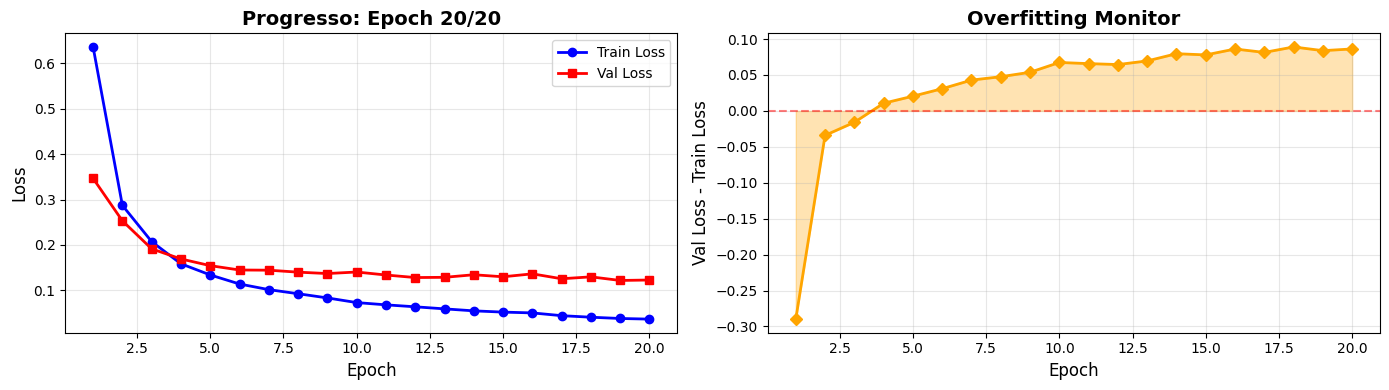

📊 Train Loss: 0.0364
📊 Val Loss:   0.1226
📊 Best Loss:  0.1216
📚 Learning Rate: 5.00e-05
⚠️  ATENÇÃO: Possível overfitting detectado!

                    ✅ TREINAMENTO CONCLUÍDO!
Total de épocas: 20
Melhor Val Loss: 0.1216 (época 20)
Modelo salvo em: /content/drive/MyDrive/clothing_segmentation_pasta/checkpoints/best_model.pt


🎉 Pronto para avaliar no test set!


In [81]:
# ==========================================
# ==========================================

from copy import deepcopy
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm

# ==========================================
# FUNÇÕES DE TREINO/VALIDAÇÃO
# ==========================================

def train_epoch(model, loader, criterion, optimizer, device):
    """
    Executa uma época de treinamento.
    """
    model.train()
    total_loss = 0
    num_batches = len(loader)

    progress_bar = tqdm(loader, desc="Treinando", leave=False)

    for imgs, masks in progress_bar:
        # Move para GPU
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(imgs)['out']
        loss = criterion(outputs, masks)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Acumula loss
        total_loss += loss.item()

        # Atualiza progress bar
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / num_batches


def eval_epoch(model, loader, criterion, device):
    """
    Executa uma época de validação.
    """
    model.eval()
    total_loss = 0
    num_batches = len(loader)

    progress_bar = tqdm(loader, desc="Validando", leave=False)

    with torch.no_grad():
        for imgs, masks in progress_bar:
            # Move para GPU
            imgs = imgs.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)

            # Forward pass
            outputs = model(imgs)['out']
            loss = criterion(outputs, masks)

            # Acumula loss
            total_loss += loss.item()

            # Atualiza progress bar
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / num_batches


# ==========================================
# VISUALIZAÇÃO
# ==========================================

def plotar_progresso(train_losses, val_losses, epoch, total_epochs):
    """
    Plota o progresso do treinamento em tempo real.
    """
    clear_output(wait=True)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

    # Gráfico de Loss
    epochs_range = range(1, len(train_losses) + 1)
    ax1.plot(epochs_range, train_losses, 'b-', label="Train Loss", linewidth=2, marker='o')
    ax1.plot(epochs_range, val_losses, 'r-', label="Val Loss", linewidth=2, marker='s')
    ax1.set_xlabel("Epoch", fontsize=12)
    ax1.set_ylabel("Loss", fontsize=12)
    ax1.set_title(f"Progresso: Epoch {epoch}/{total_epochs}", fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Gráfico de diferença Train/Val (detecta overfitting)
    if len(train_losses) > 1:
        diff = [v - t for t, v in zip(train_losses, val_losses)]
        ax2.plot(epochs_range, diff, 'orange', linewidth=2, marker='D')
        ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
        ax2.fill_between(epochs_range, 0, diff, alpha=0.3, color='orange')
        ax2.set_xlabel("Epoch", fontsize=12)
        ax2.set_ylabel("Val Loss - Train Loss", fontsize=12)
        ax2.set_title("Overfitting Monitor", fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# ==========================================
# LOOP PRINCIPAL DE TREINAMENTO
# ==========================================

def treinar_modelo(model, train_loader, val_loader, criterion, optimizer,
                   scheduler, device, epochs=20):
    """
    Loop principal de treinamento com checkpoints automáticos.

    Parâmetros:
        model: Modelo PyTorch
        train_loader: DataLoader de treino
        val_loader: DataLoader de validação
        criterion: Função de loss
        optimizer: Otimizador
        scheduler: Learning rate scheduler (pode ser None)
        device: Device (cuda/cpu)
        epochs: Número total de épocas

    Retorna:
        best_model: Melhor modelo treinado
        train_losses: Lista de train losses
        val_losses: Lista de validation losses
    """

    # Inicializa log
    inicializar_log_csv()

    # Carrega checkpoint se existir
    prev_epoch, best_loss, train_losses, val_losses = carregar_ultimo_checkpoint(
        model, optimizer, scheduler, device
    )

    # Ajusta época inicial
    start_epoch = prev_epoch + 1

    # Copia do melhor modelo
    best_model = deepcopy(model)

    # Banner inicial
    print("\n" + "="*70)
    print(" "*20 + "🚀 INICIANDO TREINAMENTO")
    print("="*70)
    print(f"Modelo: DeepLabV3-ResNet50")
    print(f"Épocas: {start_epoch} → {epochs}")
    print(f"Melhor loss anterior: {best_loss:.4f}")
    print(f"Device: {device}")
    print(f"Batch size: {train_loader.batch_size}")
    print(f"Train batches: {len(train_loader)}")
    print(f"Val batches: {len(val_loader)}")
    print("="*70 + "\n")

    # Loop de treinamento
    try:
        for epoch in range(start_epoch, epochs + 1):

            print(f"\n{'='*70}")
            print(f"Epoch {epoch}/{epochs}")
            print(f"{'='*70}")

            # ===== TREINO =====
            train_loss = train_epoch(model, train_loader, criterion, optimizer, device)

            # ===== VALIDAÇÃO =====
            val_loss = eval_epoch(model, val_loader, criterion, device)

            # ===== ATUALIZA HISTÓRICO =====
            train_losses.append(train_loss)
            val_losses.append(val_loss)

            # ===== LEARNING RATE SCHEDULER =====
            old_lr = optimizer.param_groups[0]['lr']
            if scheduler is not None:
                scheduler.step(val_loss)
            current_lr = optimizer.param_groups[0]['lr']

            # Avisa se LR mudou
            if current_lr != old_lr:
                print(f" Learning rate reduzido: {old_lr:.2e} → {current_lr:.2e}")

            # ===== SALVA MELHOR MODELO =====
            improved = False
            if val_loss < best_loss:
                best_model = deepcopy(model)
                best_loss = val_loss
                salvar_melhor_modelo(best_model, best_loss, epoch)
                improved = True

            # ===== LOGGING =====
            adicionar_log_csv(epoch, train_loss, val_loss, best_loss, current_lr)

            # ===== CHECKPOINT (a cada 5 épocas ou na última) =====
            if epoch % 5 == 0 or epoch == epochs:
                salvar_checkpoint(model, optimizer, scheduler, epoch,
                                train_losses, val_losses, best_loss)

            # ===== VISUALIZAÇÃO =====
            plotar_progresso(train_losses, val_losses, epoch, epochs)

            # ===== PRINT STATUS =====
            status_icon = "⭐" if improved else "📊"
            print(f"{status_icon} Train Loss: {train_loss:.4f}")
            print(f"{status_icon} Val Loss:   {val_loss:.4f}")
            print(f"{status_icon} Best Loss:  {best_loss:.4f}")
            print(f" Learning Rate: {current_lr:.2e}")

            # ===== AVISOS =====
            # Overfitting warning
            if val_loss > train_loss * 1.5:
                print("  ATENÇÃO: Possível overfitting detectado!")

            # Divergência warning
            if epoch > 5 and val_loss > best_loss * 2:
                print("  ATENÇÃO: Val loss divergindo muito do melhor resultado!")

            # Loss muito alta warning
            if train_loss > 10:
                print("  ATENÇÃO: Loss muito alta. Considere reduzir learning rate.")

        # Banner final
        print("\n" + "="*70)
        print(" "*20 + " TREINAMENTO CONCLUÍDO!")
        print("="*70)
        print(f"Total de épocas: {len(train_losses)}")
        print(f"Melhor Val Loss: {best_loss:.4f} (época {train_losses.index(min(train_losses)) + 1})")
        print(f"Modelo salvo em: {SAVE_DIR}/best_model.pt")
        print("="*70 + "\n")

    except KeyboardInterrupt:
        print("\n  Treinamento interrompido pelo usuário!")
        print("Salvando checkpoint atual...")
        salvar_checkpoint(model, optimizer, scheduler, epoch,
                         train_losses, val_losses, best_loss)
        print(" Checkpoint salvo! Você pode retomar o treinamento depois.")

    except Exception as e:
        print(f"\n ERRO durante treinamento: {e}")
        print(" Tentando salvar checkpoint de emergência...")
        try:
            salvar_checkpoint(model, optimizer, scheduler, epoch,
                             train_losses, val_losses, best_loss)
            print(" Checkpoint de emergência salvo!")
        except:
            print(" Não foi possível salvar checkpoint de emergência.")

    return best_model, train_losses, val_losses


# ==========================================
# EXECUÇÃO DO TREINAMENTO
# ==========================================

# Configurar número de épocas
EPOCHS = 20

print(" Iniciando treinamento...")
print(f"Total de épocas configuradas: {EPOCHS}")
print("\nPressione Ctrl+C a qualquer momento para interromper com segurança.\n")

# Executar treinamento
best_model, train_losses, val_losses = treinar_modelo(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,  # Pode ser None se não usar
    device=device,
    epochs=EPOCHS
)

print("\n🎉 Pronto para avaliar no test set!")

# 10. Gráficos de Loss e Métricas

In [85]:
# ==========================================
# MÓDULO COMPLETO DE MÉTRICAS E VISUALIZAÇÕES
# ==========================================

import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

# ==========================================
# FUNÇÕES AUXILIARES
# ==========================================

def denormalize_img(tensor_img):
    """
    Desnormaliza imagem para visualização.

    Args:
        tensor_img: Tensor CxHxW normalizado

    Returns:
        Array HxWxC com valores em [0,1]
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    img = tensor_img.cpu() * std + mean
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    return img


# ==========================================
# MÉTRICAS DE AVALIAÇÃO
# ==========================================

def pixel_accuracy(model, loader, device):
    """
    Calcula acurácia global de pixels.

    Métrica: pixels corretos / pixels totais
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Calculando Pixel Accuracy", leave=False):
            imgs = imgs.to(device)
            masks = masks.to(device)  # JÁ ESTÁ NO SHAPE CORRETO [B, H, W]

            outputs = model(imgs)['out']
            preds = torch.argmax(outputs, dim=1)

            # Ignora pixels com valor -100
            valid_mask = (masks != -100)
            correct += (preds[valid_mask] == masks[valid_mask]).sum().item()
            total += valid_mask.sum().item()

    return correct / total if total > 0 else 0.0


def mean_iou(model, loader, device, num_classes):
    """
    Calcula IoU médio (Intersection over Union) para todas as classes.

    IoU = intersection / union
    Mean IoU = média dos IoUs de cada classe
    """
    model.eval()
    iou_per_class = np.zeros(num_classes)
    count_per_class = np.zeros(num_classes)

    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Calculando Mean IoU", leave=False):
            imgs = imgs.to(device)
            masks = masks.to(device)  # [B, H, W]

            outputs = model(imgs)['out']
            preds = torch.argmax(outputs, dim=1)  # [B, H, W]

            for cls in range(num_classes):
                pred_cls = (preds == cls)
                mask_cls = (masks == cls)

                intersection = (pred_cls & mask_cls).sum().item()
                union = (pred_cls | mask_cls).sum().item()

                if union > 0:
                    iou_per_class[cls] += intersection / union
                    count_per_class[cls] += 1

    # Média apenas das classes que aparecem
    valid_classes = count_per_class > 0
    mean_iou_value = (iou_per_class[valid_classes] / count_per_class[valid_classes]).mean()

    return mean_iou_value, iou_per_class / (count_per_class + 1e-10)


def dice_score(model, loader, device, num_classes):
    """
    Calcula Dice Coefficient (F1-Score) por classe.

    Dice = 2 * intersection / (pred + target)
    """
    model.eval()
    dice_per_class = np.zeros(num_classes)
    count_per_class = np.zeros(num_classes)

    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Calculando Dice Score", leave=False):
            imgs = imgs.to(device)
            masks = masks.to(device)

            outputs = model(imgs)['out']
            preds = torch.argmax(outputs, dim=1)

            for cls in range(num_classes):
                pred_cls = (preds == cls)
                mask_cls = (masks == cls)

                intersection = (pred_cls & mask_cls).sum().item()
                pred_sum = pred_cls.sum().item()
                mask_sum = mask_cls.sum().item()

                if mask_sum > 0:  # Só calcula se a classe existe no ground truth
                    dice = (2 * intersection) / (pred_sum + mask_sum + 1e-10)
                    dice_per_class[cls] += dice
                    count_per_class[cls] += 1

    return dice_per_class / (count_per_class + 1e-10)


def classwise_pixel_accuracy(model, loader, device, num_classes):
    """
    Calcula acurácia de pixels por classe.

    Para cada classe: pixels corretos da classe / total de pixels da classe
    """
    model.eval()
    correct_per_class = np.zeros(num_classes)
    total_per_class = np.zeros(num_classes)

    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Calculando Class-wise Accuracy", leave=False):
            imgs = imgs.to(device)
            masks = masks.to(device)

            outputs = model(imgs)['out']
            preds = torch.argmax(outputs, dim=1)

            for cls in range(num_classes):
                mask_cls = (masks == cls)

                if mask_cls.sum() > 0:
                    correct_per_class[cls] += (preds[mask_cls] == cls).sum().item()
                    total_per_class[cls] += mask_cls.sum().item()

    return correct_per_class / (total_per_class + 1e-10)


def confusion_matrix_metrics(model, loader, device, num_classes):
    """
    Calcula matriz de confusão e métricas derivadas (precision, recall, F1).
    """
    model.eval()
    confusion = np.zeros((num_classes, num_classes), dtype=np.int64)

    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Calculando Confusion Matrix", leave=False):
            imgs = imgs.to(device)
            masks = masks.to(device)

            outputs = model(imgs)['out']
            preds = torch.argmax(outputs, dim=1)

            # Ignora pixels com valor -100
            valid_mask = (masks != -100)
            preds_flat = preds[valid_mask].cpu().numpy()
            masks_flat = masks[valid_mask].cpu().numpy()

            for true_cls, pred_cls in zip(masks_flat, preds_flat):
                confusion[true_cls, pred_cls] += 1

    # Calcula métricas por classe
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1 = np.zeros(num_classes)

    for cls in range(num_classes):
        tp = confusion[cls, cls]
        fp = confusion[:, cls].sum() - tp
        fn = confusion[cls, :].sum() - tp

        precision[cls] = tp / (tp + fp + 1e-10)
        recall[cls] = tp / (tp + fn + 1e-10)
        f1[cls] = 2 * (precision[cls] * recall[cls]) / (precision[cls] + recall[cls] + 1e-10)

    return confusion, precision, recall, f1


# ==========================================
# AVALIAÇÃO COMPLETA
# ==========================================

def avaliar_modelo(model, loader, device, num_classes, class_names=None):
    """
    Avalia modelo com todas as métricas e retorna relatório completo.

    Args:
        model: Modelo PyTorch
        loader: DataLoader
        device: Device (cuda/cpu)
        num_classes: Número de classes
        class_names: Lista opcional com nomes das classes

    Returns:
        dict com todas as métricas
    """
    if class_names is None:
        class_names = [f"Classe {i}" for i in range(num_classes)]

    print("\n" + "="*70)
    print(" "*20 + " AVALIAÇÃO DO MODELO")
    print("="*70)

    # Calcula métricas
    px_acc = pixel_accuracy(model, loader, device)
    mean_iou_val, iou_per_class = mean_iou(model, loader, device, num_classes)
    dice_per_class = dice_score(model, loader, device, num_classes)
    class_acc = classwise_pixel_accuracy(model, loader, device, num_classes)
    confusion, precision, recall, f1 = confusion_matrix_metrics(model, loader, device, num_classes)

    # Monta relatório
    metrics = {
        'pixel_accuracy': px_acc,
        'mean_iou': mean_iou_val,
        'iou_per_class': iou_per_class,
        'dice_per_class': dice_per_class,
        'class_accuracy': class_acc,
        'confusion_matrix': confusion,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    # Imprime resultados
    print("\n MÉTRICAS GLOBAIS:")
    print(f"   Pixel Accuracy:  {px_acc:.4f} ({px_acc*100:.2f}%)")
    print(f"   Mean IoU:        {mean_iou_val:.4f}")
    print(f"   Mean Dice:       {dice_per_class.mean():.4f}")
    print(f"   Mean Precision:  {precision.mean():.4f}")
    print(f"   Mean Recall:     {recall.mean():.4f}")
    print(f"   Mean F1-Score:   {f1.mean():.4f}")

    print("\n MÉTRICAS POR CLASSE:")
    print(f"{'Classe':<15} {'IoU':>8} {'Dice':>8} {'Acc':>8} {'Prec':>8} {'Recall':>8} {'F1':>8}")
    print("-" * 70)
    for i, name in enumerate(class_names):
        print(f"{name:<15} "
              f"{iou_per_class[i]:>8.4f} "
              f"{dice_per_class[i]:>8.4f} "
              f"{class_acc[i]:>8.4f} "
              f"{precision[i]:>8.4f} "
              f"{recall[i]:>8.4f} "
              f"{f1[i]:>8.4f}")

    print("="*70)

    return metrics


# ==========================================
# VISUALIZAÇÕES
# ==========================================

def visualize_predictions(model, dataset, device, num_samples=3, class_names=None):
    """
    Visualiza predições do modelo vs ground truth.
    """
    model.eval()

    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 3))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)
        img, mask = dataset[idx]

        # Desnormaliza imagem
        img_vis = denormalize_img(img)
        mask_vis = mask.cpu().numpy()

        # Predição
        with torch.no_grad():
            output = model(img.unsqueeze(0).to(device))['out']
            pred = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

        # Imagem Original
        axes[i, 0].imshow(img_vis)
        axes[i, 0].set_title("Imagem Original", fontsize=12, fontweight='bold')
        axes[i, 0].axis("off")

        # Ground Truth
        axes[i, 1].imshow(mask_vis, cmap="tab10", vmin=0, vmax=9)
        axes[i, 1].set_title("Ground Truth", fontsize=12, fontweight='bold')
        axes[i, 1].axis("off")

        # Predição
        axes[i, 2].imshow(pred, cmap="tab10", vmin=0, vmax=9)
        axes[i, 2].set_title("Predição", fontsize=12, fontweight='bold')
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(confusion_matrix, class_names=None):
    """
    Plota matriz de confusão.
    """
    num_classes = confusion_matrix.shape[0]
    if class_names is None:
        class_names = [f"C{i}" for i in range(num_classes)]

    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(confusion_matrix, cmap='Blues', aspect='auto')

    # Configurar eixos
    ax.set_xticks(np.arange(num_classes))
    ax.set_yticks(np.arange(num_classes))
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_yticklabels(class_names)

    # Adicionar valores
    for i in range(num_classes):
        for j in range(num_classes):
            text = ax.text(j, i, confusion_matrix[i, j],
                          ha="center", va="center", color="white" if confusion_matrix[i, j] > confusion_matrix.max()/2 else "black")

    ax.set_title("Matriz de Confusão", fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel("Predito", fontsize=12)
    ax.set_ylabel("Real", fontsize=12)

    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()


def plot_metrics_comparison(metrics, class_names=None):
    """
    Plota comparação de métricas por classe.
    """
    num_classes = len(metrics['iou_per_class'])
    if class_names is None:
        class_names = [f"Classe {i}" for i in range(num_classes)]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    x = np.arange(num_classes)
    width = 0.35

    # IoU e Dice
    axes[0, 0].bar(x - width/2, metrics['iou_per_class'], width, label='IoU', alpha=0.8)
    axes[0, 0].bar(x + width/2, metrics['dice_per_class'], width, label='Dice', alpha=0.8)
    axes[0, 0].set_xlabel('Classes')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].set_title('IoU e Dice por Classe')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(class_names, rotation=45, ha='right')
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', alpha=0.3)

    # Precision, Recall, F1
    axes[0, 1].bar(x - width, metrics['precision'], width, label='Precision', alpha=0.8)
    axes[0, 1].bar(x, metrics['recall'], width, label='Recall', alpha=0.8)
    axes[0, 1].bar(x + width, metrics['f1_score'], width, label='F1', alpha=0.8)
    axes[0, 1].set_xlabel('Classes')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_title('Precision, Recall e F1 por Classe')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(class_names, rotation=45, ha='right')
    axes[0, 1].legend()
    axes[0, 1].grid(axis='y', alpha=0.3)

    # Class Accuracy
    axes[1, 0].bar(x, metrics['class_accuracy'], alpha=0.8, color='green')
    axes[1, 0].set_xlabel('Classes')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].set_title('Acurácia por Classe')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(class_names, rotation=45, ha='right')
    axes[1, 0].grid(axis='y', alpha=0.3)

    # Resumo
    global_metrics = [
        metrics['pixel_accuracy'],
        metrics['mean_iou'],
        metrics['dice_per_class'].mean(),
        metrics['precision'].mean(),
        metrics['recall'].mean(),
        metrics['f1_score'].mean()
    ]
    metric_names = ['Pixel Acc', 'Mean IoU', 'Mean Dice', 'Mean Prec', 'Mean Recall', 'Mean F1']

    axes[1, 1].bar(metric_names, global_metrics, alpha=0.8, color='orange')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_title('Métricas Globais')
    axes[1, 1].set_xticklabels(metric_names, rotation=45, ha='right')
    axes[1, 1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()


# ==========================================
# EXEMPLO DE USO
# ==========================================

# Defina os nomes das suas classes (ajuste conforme seu dataset)
CLASS_NAMES = ["Classe 0", "Classe 1", "Classe 2", "Classe 3", "Classe 4"]

print("="*70)
print(" "*15 + " MÓDULO DE MÉTRICAS CARREGADO")
print("="*70)
print("\nFunções disponíveis:")
print("  - avaliar_modelo(): Avaliação completa com todas as métricas")
print("  - visualize_predictions(): Visualiza predições vs ground truth")
print("  - plot_confusion_matrix(): Plota matriz de confusão")
print("  - plot_metrics_comparison(): Compara métricas por classe")
print("\nUso após o treinamento:")
print("  metrics = avaliar_modelo(best_model, val_loader, device, NUM_CLASSES, CLASS_NAMES)")
print("  visualize_predictions(best_model, val_dataset, device, num_samples=5)")
print("="*70)

                MÓDULO DE MÉTRICAS CARREGADO

Funções disponíveis:
  - avaliar_modelo(): Avaliação completa com todas as métricas
  - visualize_predictions(): Visualiza predições vs ground truth
  - plot_confusion_matrix(): Plota matriz de confusão
  - plot_metrics_comparison(): Compara métricas por classe

Uso após o treinamento:
  metrics = avaliar_modelo(best_model, val_loader, device, NUM_CLASSES, CLASS_NAMES)
  visualize_predictions(best_model, val_dataset, device, num_samples=5)


# 11. SCRIPT DE AVALIAÇÃO COMPLETA


 CLASSES DO MODELO:
  0 (ID original 34): Upper-clothes
  1 (ID original 43): Dress
  2 (ID original 78): Pants
  3 (ID original 81): Skirt
  4 (ID original 91): Bag

 Carregando melhor modelo...
Melhor modelo carregado!
   Época: 19
   Val Loss: 0.1216

               AVALIAÇÃO NO CONJUNTO DE VALIDAÇÃO

                    📊 AVALIAÇÃO DO MODELO



📈 MÉTRICAS GLOBAIS:
   Pixel Accuracy:  0.9622 (96.22%)
   Mean IoU:        0.3917
   Mean Dice:       0.5085
   Mean Precision:  0.7578
   Mean Recall:     0.6918
   Mean F1-Score:   0.7216

📊 MÉTRICAS POR CLASSE:
Classe               IoU     Dice      Acc     Prec   Recall       F1
----------------------------------------------------------------------
Upper-clothes     0.8872   0.9395   0.9909   0.9806   0.9912   0.9858
Dress             0.1126   0.1954   0.3240   0.5031   0.3617   0.4208
Pants             0.2844   0.4219   0.6946   0.7863   0.7090   0.7457
Skirt             0.3653   0.5275   0.7197   0.8030   0.7238   0.7613
Bag               0.3089   0.4580   0.6790   0.7159   0.6736   0.6941

 Métricas salvas em: /content/drive/MyDrive/clothing_segmentation_pasta/checkpoints/metrics_validation.json

                   AVALIAÇÃO NO CONJUNTO DE TESTE

                    📊 AVALIAÇÃO DO MODELO



📈 MÉTRICAS GLOBAIS:
   Pixel Accuracy:  0.9625 (96.25%)
   Mean IoU:        0.3835
   Mean Dice:       0.4870
   Mean Precision:  0.7555
   Mean Recall:     0.6753
   Mean F1-Score:   0.7108

📊 MÉTRICAS POR CLASSE:
Classe               IoU     Dice      Acc     Prec   Recall       F1
----------------------------------------------------------------------
Upper-clothes     0.8872   0.9397   0.9919   0.9786   0.9921   0.9853
Dress             0.1410   0.2231   0.3514   0.4950   0.3427   0.4050
Pants             0.2472   0.3512   0.6933   0.7705   0.6860   0.7258
Skirt             0.3245   0.4443   0.6992   0.8241   0.6866   0.7491
Bag               0.3178   0.4765   0.6792   0.7093   0.6691   0.6886

 Métricas de teste salvas em: /content/drive/MyDrive/clothing_segmentation_pasta/checkpoints/metrics_test.json

                     GERANDO VISUALIZAÇÕES

1. Matriz de Confusão (Validação):


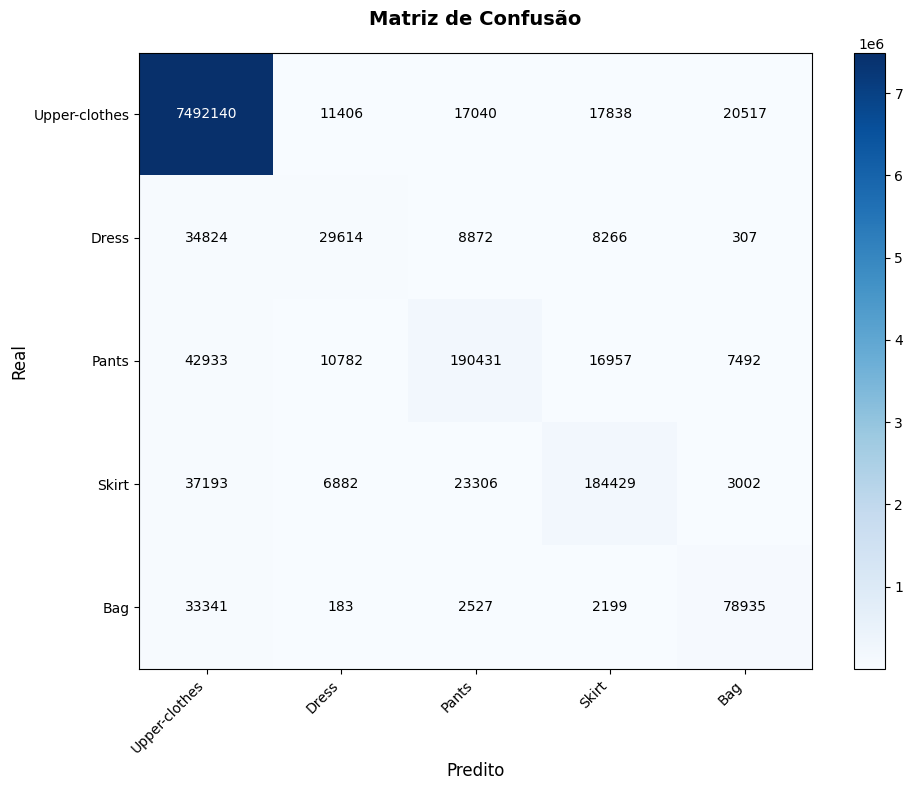


2. Comparação de Métricas (Validação):


/tmp/ipython-input-2447279225.py:412: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(metric_names, rotation=45, ha='right')


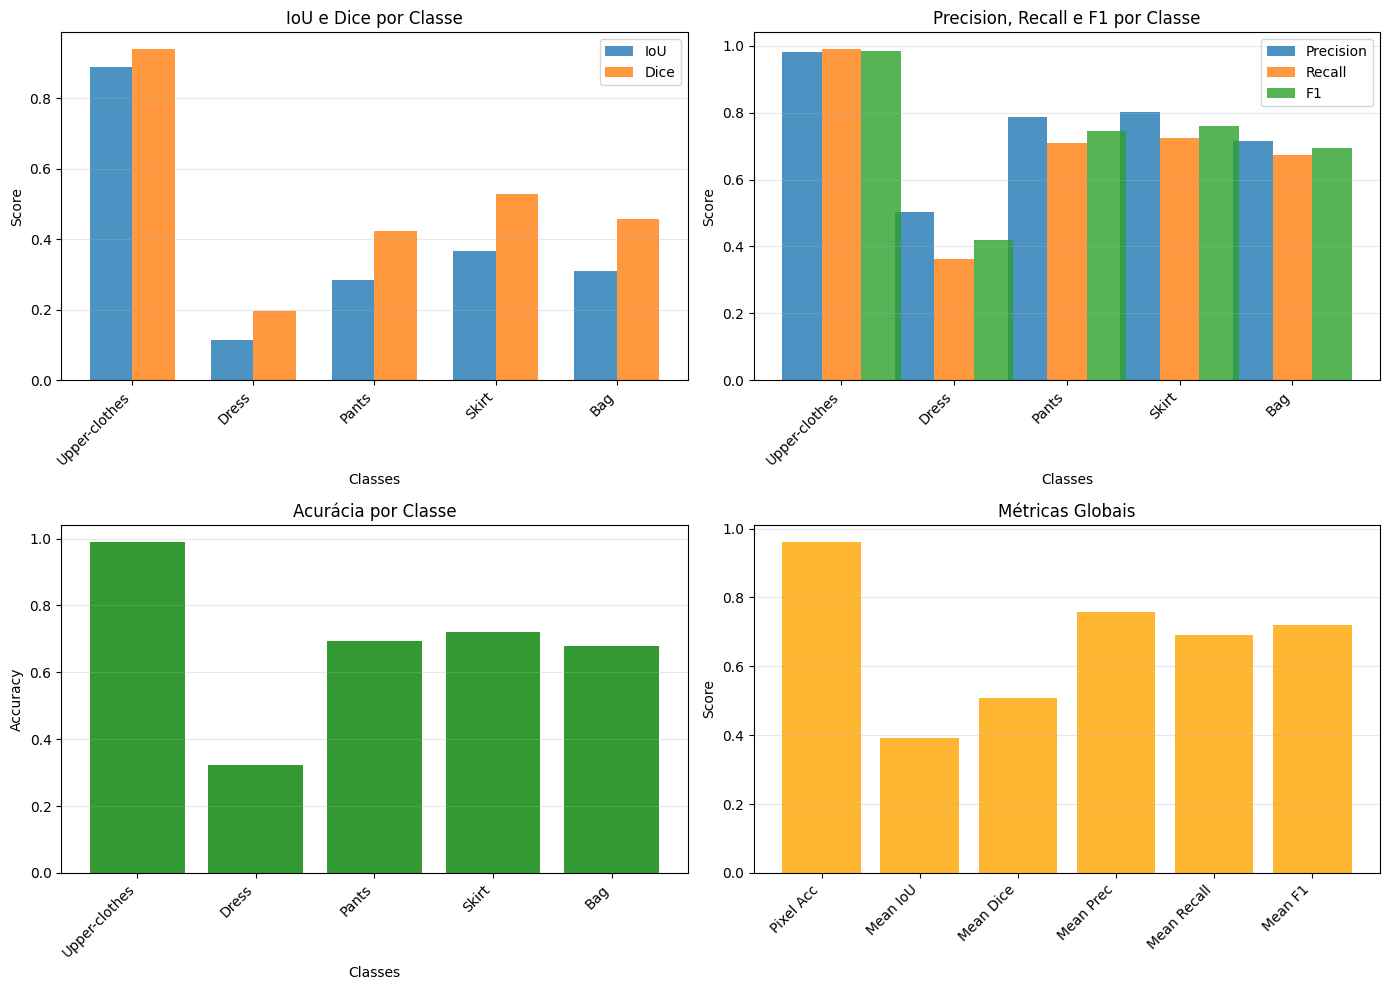


3. Visualizações de Predições (Validação):


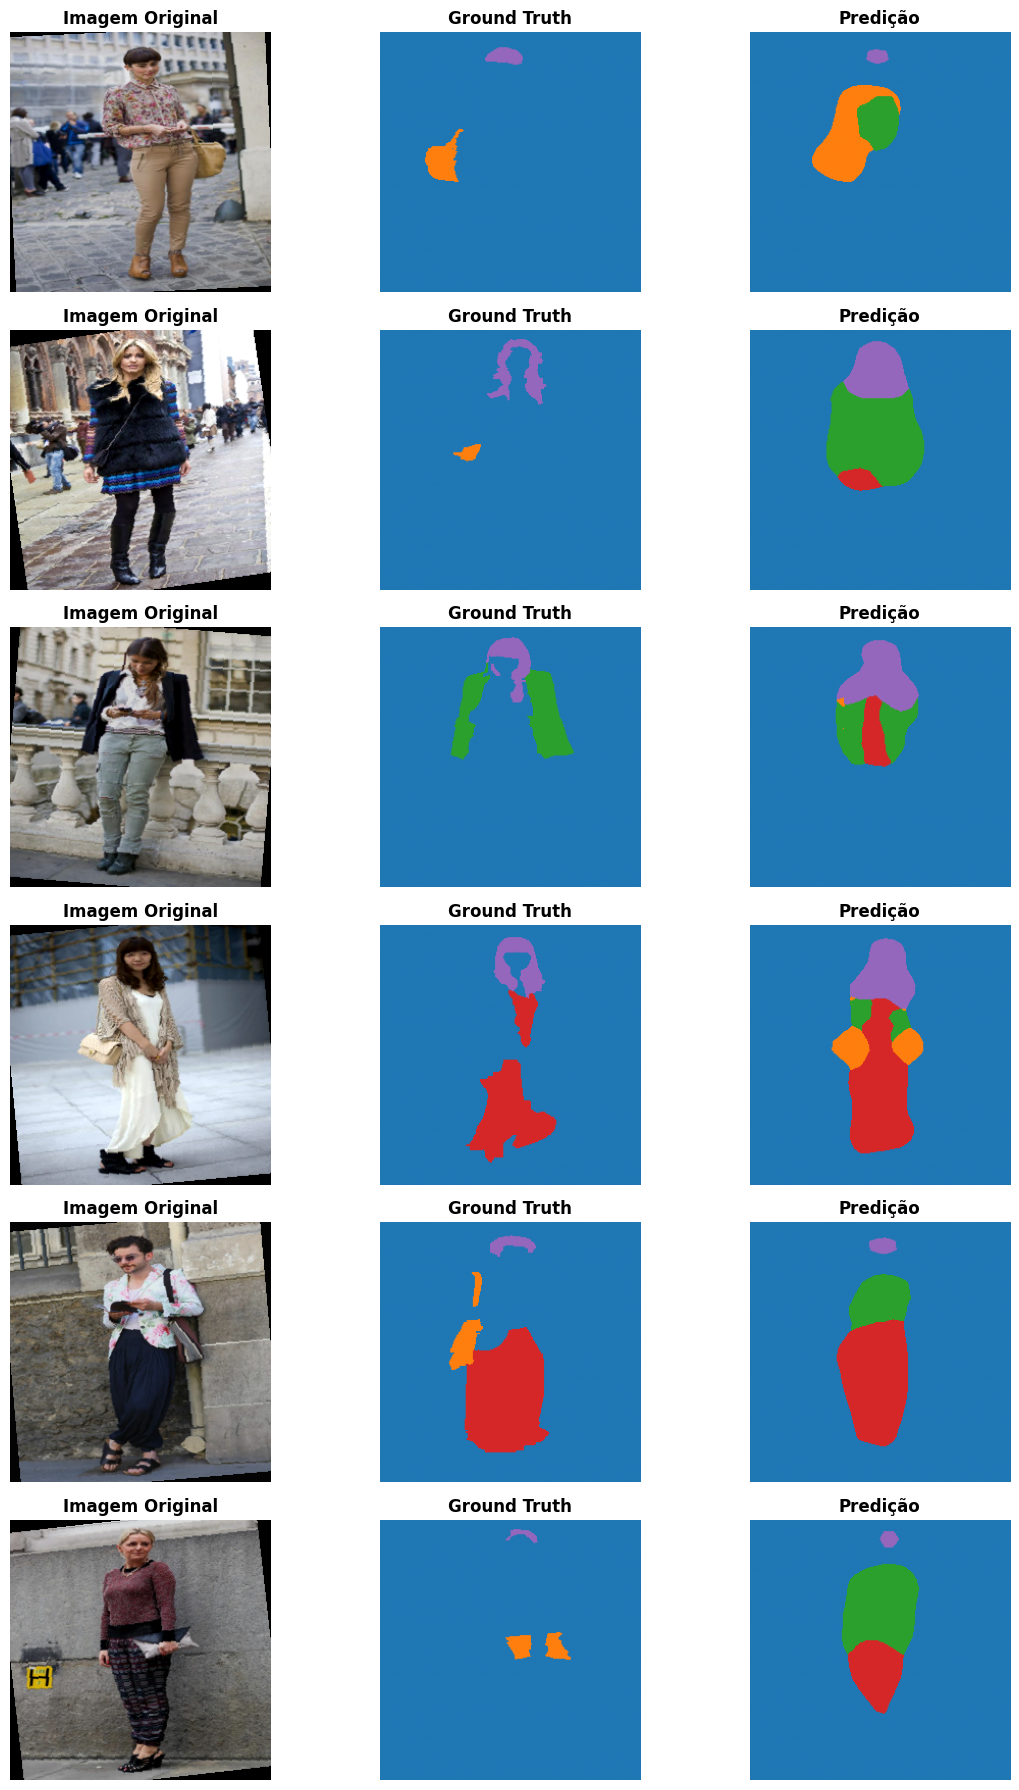


4. Visualizações de Predições (Teste):


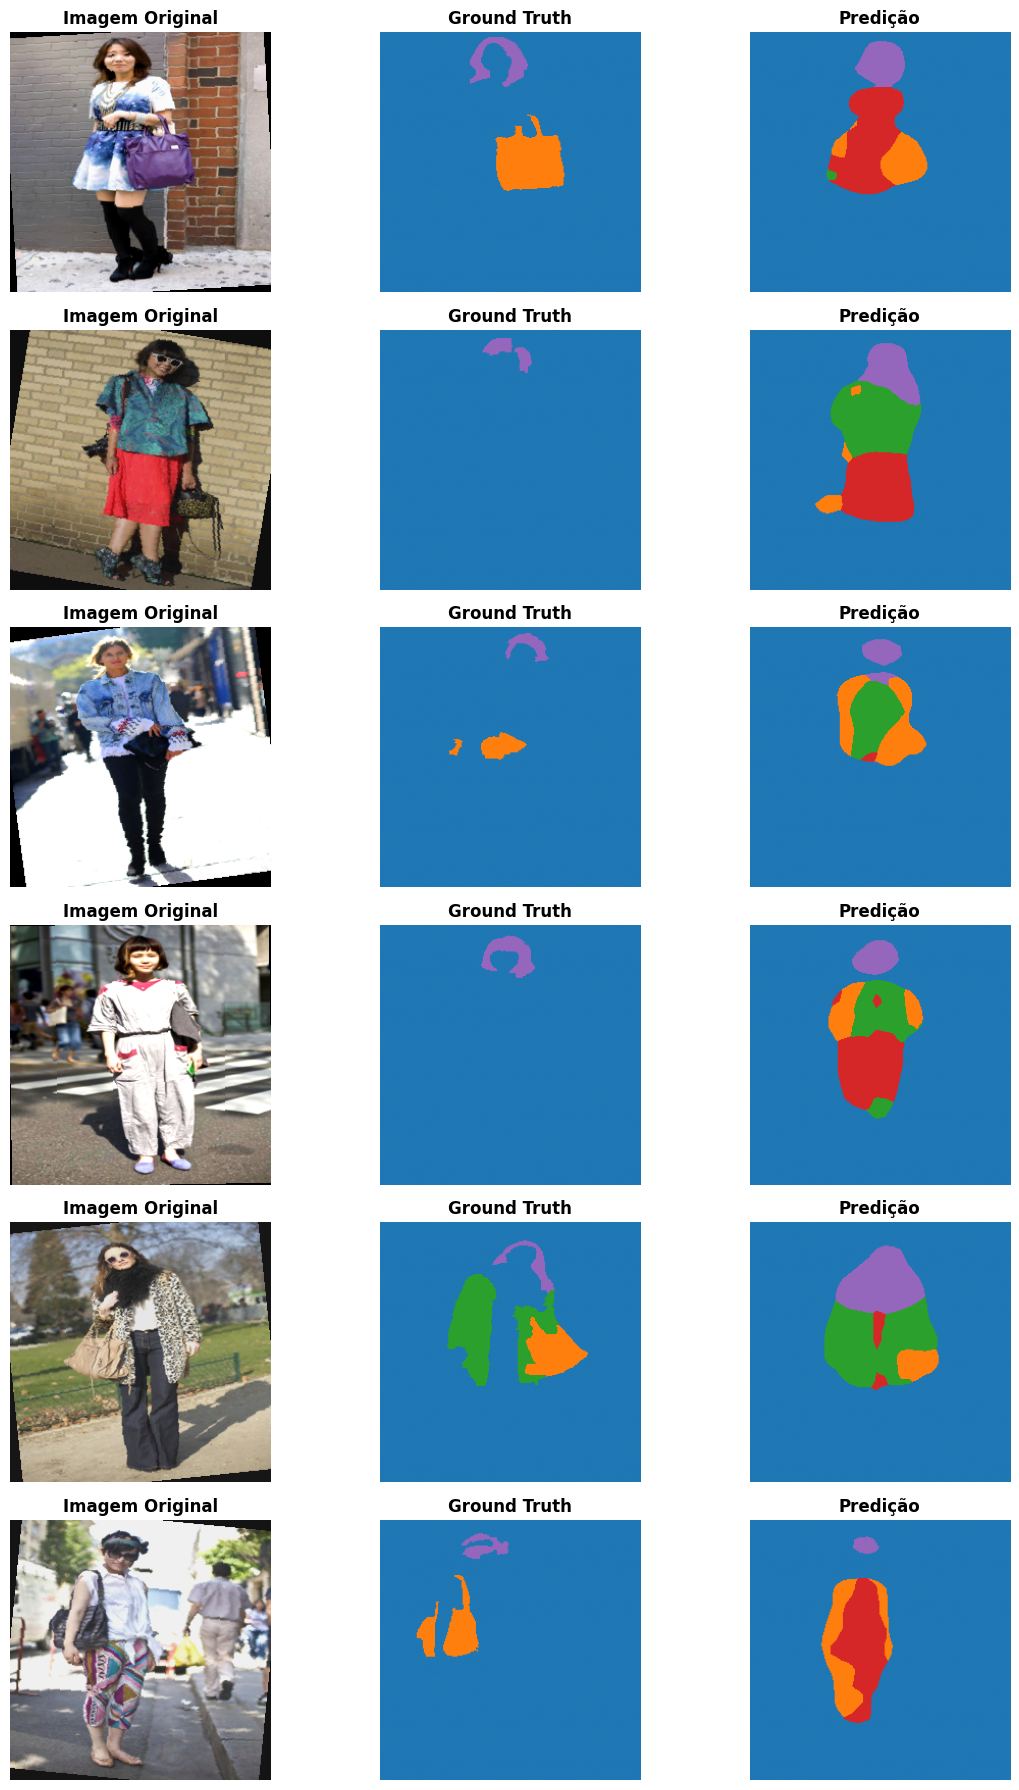


               COMPARAÇÃO: VALIDAÇÃO vs TESTE


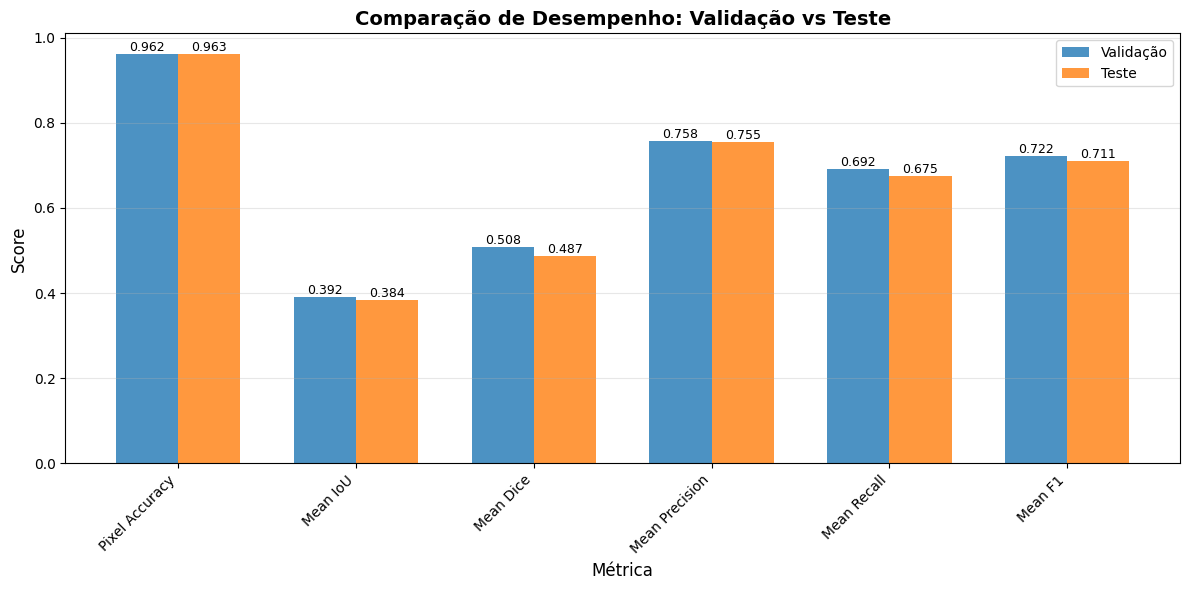


TABELA DE COMPARAÇÃO:
Métrica                 Validação        Teste    Diferença
------------------------------------------------------------
Pixel Accuracy             0.9622       0.9625      +0.0003
Mean IoU                   0.3917       0.3835      -0.0082
Mean Dice                  0.5085       0.4870      -0.0215
Mean Precision             0.7578       0.7555      -0.0023
Mean Recall                0.6918       0.6753      -0.0165
Mean F1                    0.7216       0.7108      -0.0108

                  ANÁLISE DE ERRO POR CLASSE


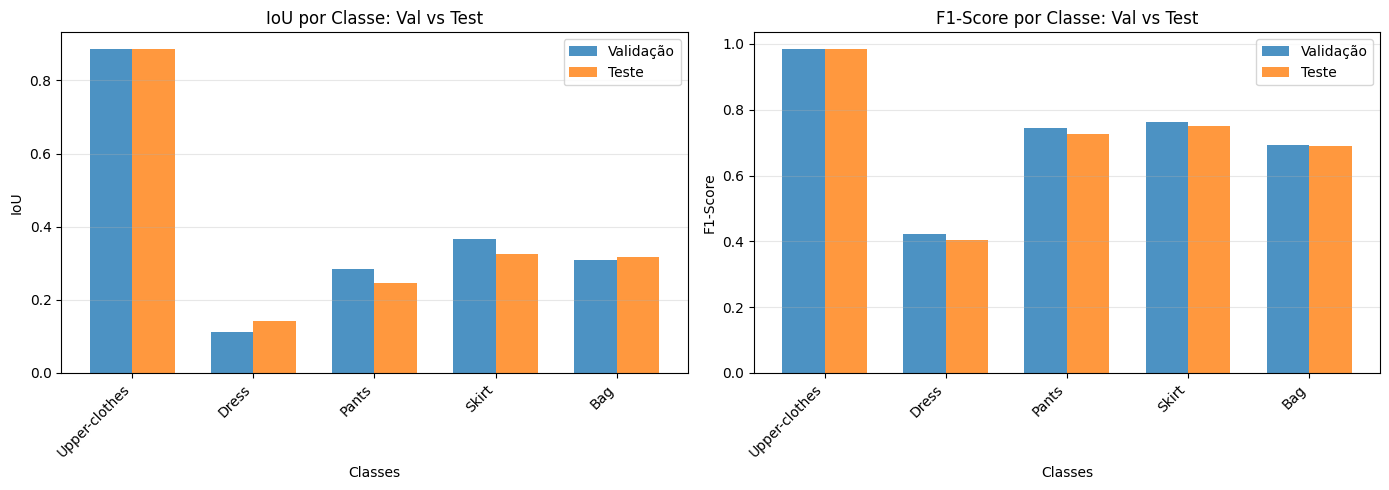


               ANÁLISE DE CLASSES PROBLEMÁTICAS

Classes com IoU < 0.5 (TESTE):
 Dress: IoU = 0.1410
 Pants: IoU = 0.2472
 Skirt: IoU = 0.3245
 Bag: IoU = 0.3178

Classes com F1-Score < 0.6 (TESTE):
  Dress: F1 = 0.4050

 SUGESTÕES DE MELHORIA:
  1. Aumentar data augmentation para classes problemáticas
  2. Usar class weights no CrossEntropyLoss
  3. Aumentar número de épocas de treinamento
  4. Usar técnicas de oversampling para classes minoritárias
  5. Experimentar outros backbones (ResNet101, EfficientNet)

                     SALVANDO VISUALIZAÇÕES


<Figure size 1000x800 with 0 Axes>

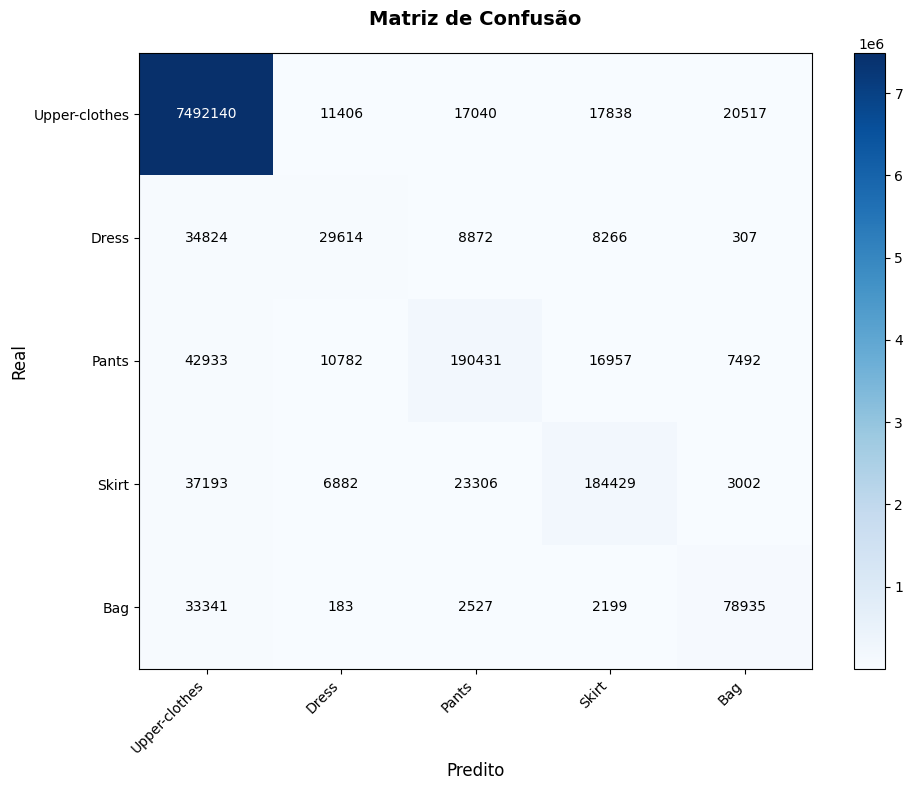

<Figure size 1000x800 with 0 Axes>

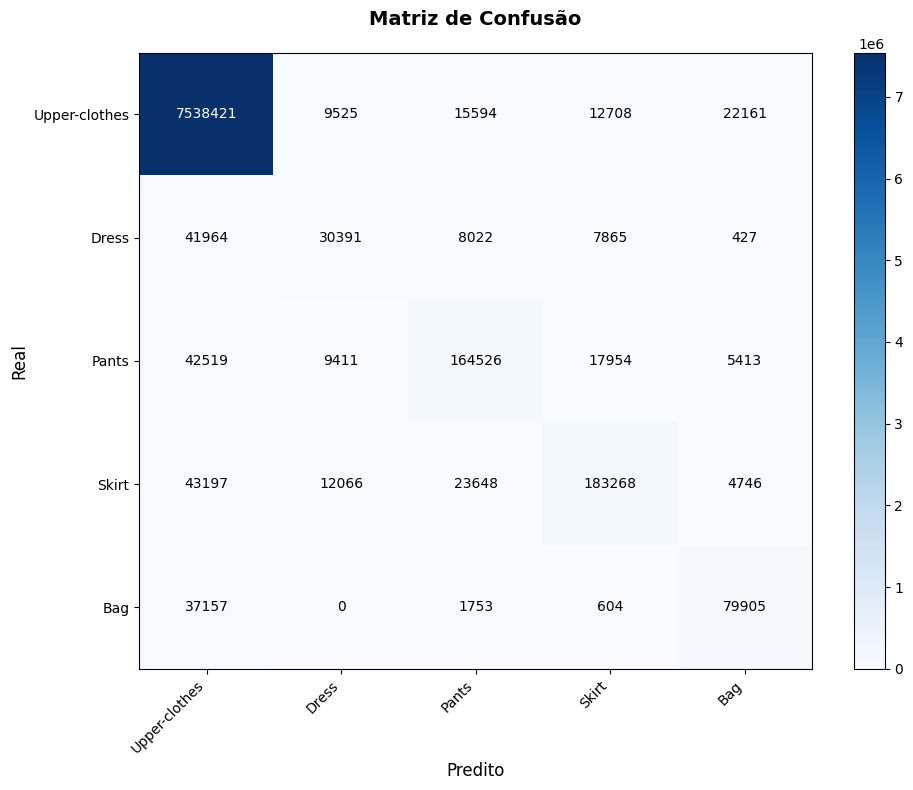

/tmp/ipython-input-2447279225.py:412: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(metric_names, rotation=45, ha='right')


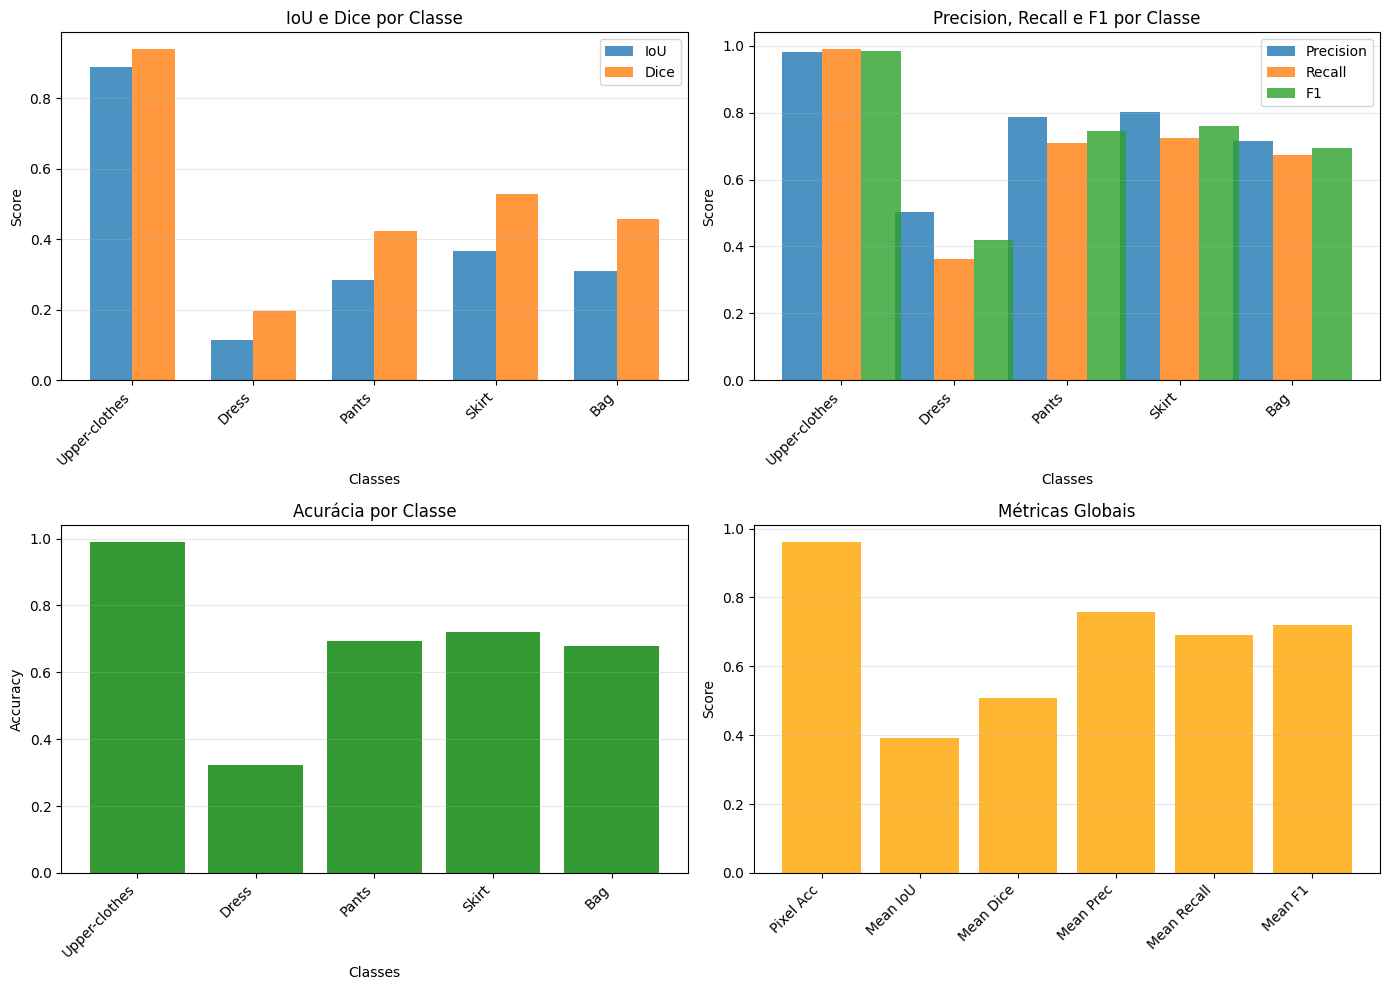

/tmp/ipython-input-2447279225.py:412: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(metric_names, rotation=45, ha='right')


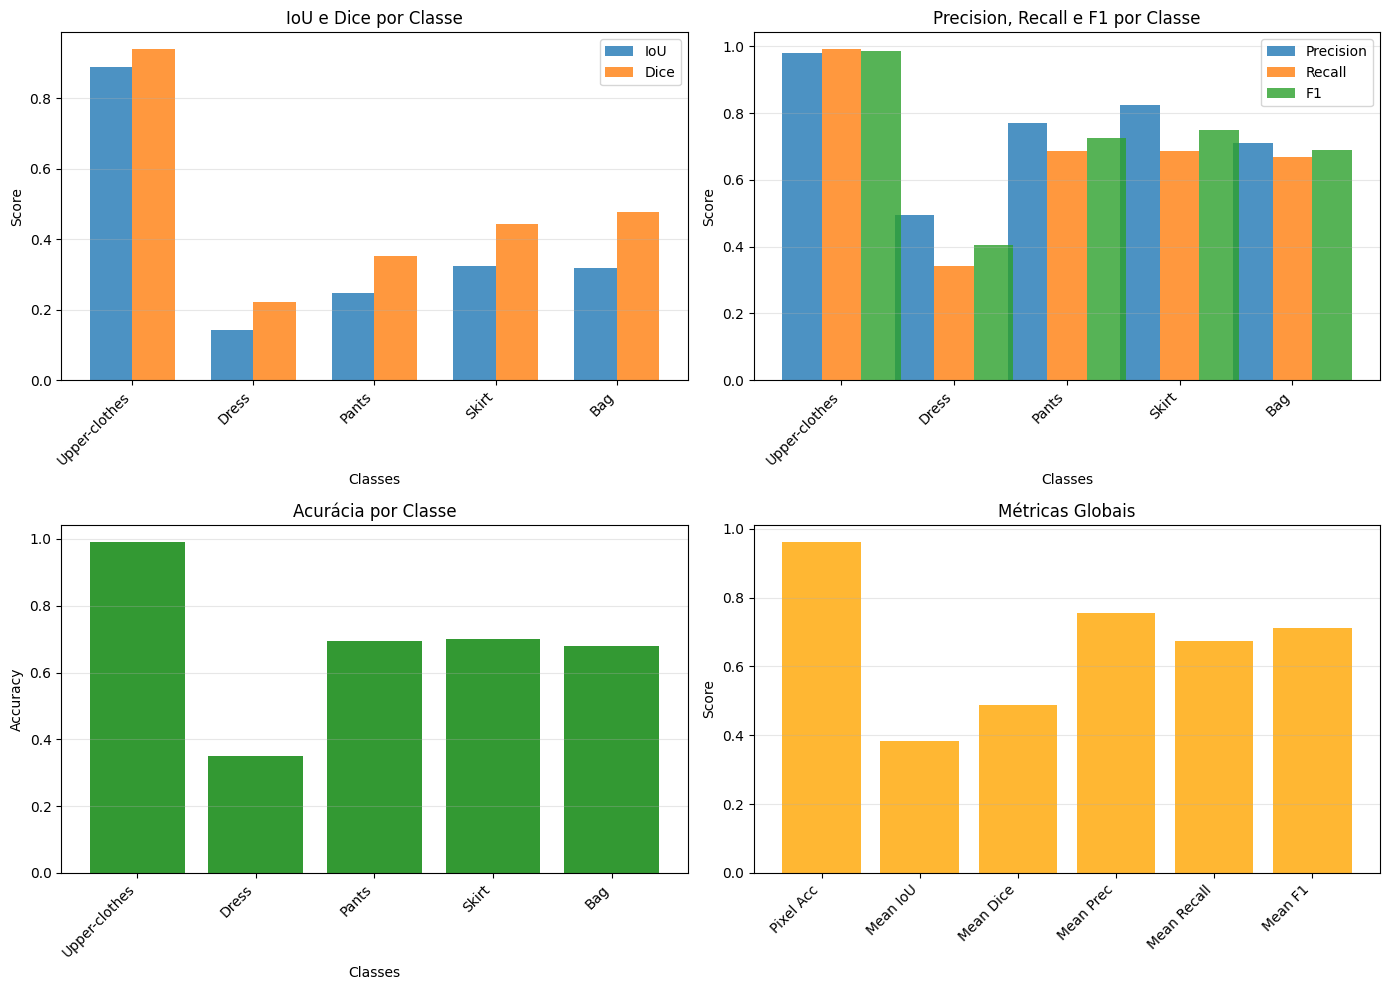

 Gráficos salvos em: /content/drive/MyDrive/clothing_segmentation_pasta/checkpoints/evaluation_graphs

                     GERANDO RELATÓRIO FINAL
 Relatório salvo em: /content/drive/MyDrive/clothing_segmentation_pasta/checkpoints/evaluation_report.txt

                     AVALIAÇÃO COMPLETA!

📊 RESUMO DOS RESULTADOS:

  VALIDAÇÃO:
    • Pixel Accuracy: 96.22%
    • Mean IoU:       0.3917
    • Mean F1:        0.7216

  TESTE:
    • Pixel Accuracy: 96.25%
    • Mean IoU:       0.3835
    • Mean F1:        0.7108

 ARQUIVOS GERADOS:
    • Métricas (JSON):     /content/drive/MyDrive/clothing_segmentation_pasta/checkpoints/metrics_*.json
    • Relatório (TXT):     /content/drive/MyDrive/clothing_segmentation_pasta/checkpoints/evaluation_report.txt
    • Gráficos (PNG):      /content/drive/MyDrive/clothing_segmentation_pasta/checkpoints/evaluation_graphs/
    • Modelo (PT):         /content/drive/MyDrive/clothing_segmentation_pasta/checkpoints/best_model.pt

                AVALIAÇÃO FIN

In [84]:
# ==========================================
# 1. DEFINIR NOMES DAS CLASSES
# ==========================================

# Mapeie os IDs originais para nomes descritivos
CLASS_ID_TO_NAME = {
    34: "Upper-clothes",
    43: "Dress",
    78: "Pants",
    81: "Skirt",
    91: "Bag"
}

# Ou use os IDs diretamente se não souber os nomes
CLASS_NAMES = [CLASS_ID_TO_NAME.get(id, f"Classe {id}") for id in TOP_CLASSES]

print("="*70)
print(" CLASSES DO MODELO:")
print("="*70)
for i, (orig_id, name) in enumerate(zip(TOP_CLASSES, CLASS_NAMES)):
    print(f"  {i} (ID original {orig_id}): {name}")
print("="*70)


# ==========================================
# 2. CARREGAR MELHOR MODELO
# ==========================================

print("\n Carregando melhor modelo...")

# Cria nova instância do modelo
from torchvision.models.segmentation import deeplabv3_resnet50

eval_model = deeplabv3_resnet50(weights=None)
eval_model.classifier[-1] = torch.nn.Conv2d(256, NUM_CLASSES, kernel_size=(1,1))

# Carrega pesos do melhor modelo
best_model_path = os.path.join(SAVE_DIR, "best_model.pt")

if os.path.exists(best_model_path):
    checkpoint = torch.load(best_model_path, map_location=device)
    eval_model.load_state_dict(checkpoint['model_state'])
    eval_model = eval_model.to(device)
    eval_model.eval()

    print(f"Melhor modelo carregado!")
    print(f"   Época: {checkpoint.get('epoch', 'N/A')}")
    print(f"   Val Loss: {checkpoint.get('best_loss', 'N/A'):.4f}")
else:
    print(" Arquivo best_model.pt não encontrado. Usando modelo atual.")
    eval_model = best_model
    eval_model.eval()


# ==========================================
# 3. AVALIAÇÃO NO CONJUNTO DE VALIDAÇÃO
# ==========================================

print("\n" + "="*70)
print(" "*15 + "AVALIAÇÃO NO CONJUNTO DE VALIDAÇÃO")
print("="*70)

metrics_val = avaliar_modelo(
    model=eval_model,
    loader=val_loader,
    device=device,
    num_classes=NUM_CLASSES,
    class_names=CLASS_NAMES
)

# Salva métricas em arquivo
import json
metrics_file = os.path.join(SAVE_DIR, "metrics_validation.json")
with open(metrics_file, 'w') as f:
    # Converte arrays numpy para listas
    metrics_to_save = {
        'pixel_accuracy': float(metrics_val['pixel_accuracy']),
        'mean_iou': float(metrics_val['mean_iou']),
        'iou_per_class': metrics_val['iou_per_class'].tolist(),
        'dice_per_class': metrics_val['dice_per_class'].tolist(),
        'class_accuracy': metrics_val['class_accuracy'].tolist(),
        'precision': metrics_val['precision'].tolist(),
        'recall': metrics_val['recall'].tolist(),
        'f1_score': metrics_val['f1_score'].tolist(),
        'class_names': CLASS_NAMES
    }
    json.dump(metrics_to_save, f, indent=2)

print(f"\n Métricas salvas em: {metrics_file}")


# ==========================================
# 4. AVALIAÇÃO NO CONJUNTO DE TESTE
# ==========================================

print("\n" + "="*70)
print(" "*18 + " AVALIAÇÃO NO CONJUNTO DE TESTE")
print("="*70)

metrics_test = avaliar_modelo(
    model=eval_model,
    loader=test_loader,
    device=device,
    num_classes=NUM_CLASSES,
    class_names=CLASS_NAMES
)

# Salva métricas de teste
metrics_test_file = os.path.join(SAVE_DIR, "metrics_test.json")
with open(metrics_test_file, 'w') as f:
    metrics_to_save = {
        'pixel_accuracy': float(metrics_test['pixel_accuracy']),
        'mean_iou': float(metrics_test['mean_iou']),
        'iou_per_class': metrics_test['iou_per_class'].tolist(),
        'dice_per_class': metrics_test['dice_per_class'].tolist(),
        'class_accuracy': metrics_test['class_accuracy'].tolist(),
        'precision': metrics_test['precision'].tolist(),
        'recall': metrics_test['recall'].tolist(),
        'f1_score': metrics_test['f1_score'].tolist(),
        'class_names': CLASS_NAMES
    }
    json.dump(metrics_to_save, f, indent=2)

print(f"\n Métricas de teste salvas em: {metrics_test_file}")


# ==========================================
# 5. VISUALIZAÇÕES
# ==========================================

print("\n" + "="*70)
print(" "*20 + " GERANDO VISUALIZAÇÕES")
print("="*70)

# Matriz de Confusão (Validação)
print("\n1. Matriz de Confusão (Validação):")
plot_confusion_matrix(metrics_val['confusion_matrix'], CLASS_NAMES)

# Comparação de Métricas (Validação)
print("\n2. Comparação de Métricas (Validação):")
plot_metrics_comparison(metrics_val, CLASS_NAMES)

# Predições Qualitativas (Validação)
print("\n3. Visualizações de Predições (Validação):")
visualize_predictions(eval_model, val_dataset, device, num_samples=6, class_names=CLASS_NAMES)

# Predições Qualitativas (Teste)
print("\n4. Visualizações de Predições (Teste):")
visualize_predictions(eval_model, test_dataset, device, num_samples=6, class_names=CLASS_NAMES)


# ==========================================
# 6. COMPARAÇÃO VAL vs TEST
# ==========================================

print("\n" + "="*70)
print(" "*15 + "COMPARAÇÃO: VALIDAÇÃO vs TESTE")
print("="*70)

comparison_data = {
    'Pixel Accuracy': [metrics_val['pixel_accuracy'], metrics_test['pixel_accuracy']],
    'Mean IoU': [metrics_val['mean_iou'], metrics_test['mean_iou']],
    'Mean Dice': [metrics_val['dice_per_class'].mean(), metrics_test['dice_per_class'].mean()],
    'Mean Precision': [metrics_val['precision'].mean(), metrics_test['precision'].mean()],
    'Mean Recall': [metrics_val['recall'].mean(), metrics_test['recall'].mean()],
    'Mean F1': [metrics_val['f1_score'].mean(), metrics_test['f1_score'].mean()]
}

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(comparison_data))
width = 0.35

val_scores = [v[0] for v in comparison_data.values()]
test_scores = [v[1] for v in comparison_data.values()]

bars1 = ax.bar(x - width/2, val_scores, width, label='Validação', alpha=0.8)
bars2 = ax.bar(x + width/2, test_scores, width, label='Teste', alpha=0.8)

ax.set_xlabel('Métrica', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Comparação de Desempenho: Validação vs Teste', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_data.keys(), rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Adiciona valores nas barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Tabela de comparação
print("\nTABELA DE COMPARAÇÃO:")
print(f"{'Métrica':<20} {'Validação':>12} {'Teste':>12} {'Diferença':>12}")
print("-" * 60)
for metric_name, (val_score, test_score) in comparison_data.items():
    diff = test_score - val_score
    print(f"{metric_name:<20} {val_score:>12.4f} {test_score:>12.4f} {diff:>+12.4f}")


# ==========================================
# 7. ANÁLISE DE ERRO POR CLASSE
# ==========================================

print("\n" + "="*70)
print(" "*18 + "ANÁLISE DE ERRO POR CLASSE")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Comparação IoU por classe
x = np.arange(NUM_CLASSES)
width = 0.35

axes[0].bar(x - width/2, metrics_val['iou_per_class'], width, label='Validação', alpha=0.8)
axes[0].bar(x + width/2, metrics_test['iou_per_class'], width, label='Teste', alpha=0.8)
axes[0].set_xlabel('Classes')
axes[0].set_ylabel('IoU')
axes[0].set_title('IoU por Classe: Val vs Test')
axes[0].set_xticks(x)
axes[0].set_xticklabels(CLASS_NAMES, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Comparação F1 por classe
axes[1].bar(x - width/2, metrics_val['f1_score'], width, label='Validação', alpha=0.8)
axes[1].bar(x + width/2, metrics_test['f1_score'], width, label='Teste', alpha=0.8)
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('F1-Score')
axes[1].set_title('F1-Score por Classe: Val vs Test')
axes[1].set_xticks(x)
axes[1].set_xticklabels(CLASS_NAMES, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


# ==========================================
# 8. IDENTIFICAR CLASSES PROBLEMÁTICAS
# ==========================================

print("\n" + "="*70)
print(" "*15 + "ANÁLISE DE CLASSES PROBLEMÁTICAS")
print("="*70)

# Define threshold para considerar uma classe problemática
THRESHOLD_IOU = 0.5
THRESHOLD_F1 = 0.6

print("\nClasses com IoU < 0.5 (TESTE):")
problematic_iou = []
for i, (name, iou) in enumerate(zip(CLASS_NAMES, metrics_test['iou_per_class'])):
    if iou < THRESHOLD_IOU:
        print(f" {name}: IoU = {iou:.4f}")
        problematic_iou.append((name, iou))

if not problematic_iou:
    print(" Todas as classes têm IoU >= 0.5")

print("\nClasses com F1-Score < 0.6 (TESTE):")
problematic_f1 = []
for i, (name, f1) in enumerate(zip(CLASS_NAMES, metrics_test['f1_score'])):
    if f1 < THRESHOLD_F1:
        print(f"  {name}: F1 = {f1:.4f}")
        problematic_f1.append((name, f1))

if not problematic_f1:
    print(" Todas as classes têm F1-Score >= 0.6")

# Sugestões de melhoria
if problematic_iou or problematic_f1:
    print("\n SUGESTÕES DE MELHORIA:")
    print("  1. Aumentar data augmentation para classes problemáticas")
    print("  2. Usar class weights no CrossEntropyLoss")
    print("  3. Aumentar número de épocas de treinamento")
    print("  4. Usar técnicas de oversampling para classes minoritárias")
    print("  5. Experimentar outros backbones (ResNet101, EfficientNet)")


# ==========================================
# 9. SALVAR GRÁFICOS NO DRIVE
# ==========================================

print("\n" + "="*70)
print(" "*20 + " SALVANDO VISUALIZAÇÕES")
print("="*70)

# Cria pasta para gráficos
graphs_dir = os.path.join(SAVE_DIR, "evaluation_graphs")
os.makedirs(graphs_dir, exist_ok=True)

# Confusion Matrix (Val)
fig = plt.figure(figsize=(10, 8))
plot_confusion_matrix(metrics_val['confusion_matrix'], CLASS_NAMES)
plt.savefig(os.path.join(graphs_dir, "confusion_matrix_val.png"), dpi=300, bbox_inches='tight')
plt.close()

# Confusion Matrix (Test)
fig = plt.figure(figsize=(10, 8))
plot_confusion_matrix(metrics_test['confusion_matrix'], CLASS_NAMES)
plt.savefig(os.path.join(graphs_dir, "confusion_matrix_test.png"), dpi=300, bbox_inches='tight')
plt.close()

# Metrics Comparison (Val)
plot_metrics_comparison(metrics_val, CLASS_NAMES)
plt.savefig(os.path.join(graphs_dir, "metrics_comparison_val.png"), dpi=300, bbox_inches='tight')
plt.close()

# Metrics Comparison (Test)
plot_metrics_comparison(metrics_test, CLASS_NAMES)
plt.savefig(os.path.join(graphs_dir, "metrics_comparison_test.png"), dpi=300, bbox_inches='tight')
plt.close()

print(f" Gráficos salvos em: {graphs_dir}")


# ==========================================
# 10. RELATÓRIO FINAL EM TEXTO
# ==========================================

print("\n" + "="*70)
print(" "*20 + " GERANDO RELATÓRIO FINAL")
print("="*70)

report_path = os.path.join(SAVE_DIR, "evaluation_report.txt")

with open(report_path, 'w', encoding='utf-8') as f:
    f.write("="*70 + "\n")
    f.write(" "*15 + "RELATÓRIO DE AVALIAÇÃO DO MODELO\n")
    f.write("="*70 + "\n\n")

    f.write("INFORMAÇÕES DO MODELO:\n")
    f.write("-"*70 + "\n")
    f.write(f"Arquitetura: DeepLabV3-ResNet50\n")
    f.write(f"Número de classes: {NUM_CLASSES}\n")
    f.write(f"Classes: {', '.join(CLASS_NAMES)}\n")
    f.write(f"Dataset: Clothing Co-Parsing\n\n")

    f.write("MÉTRICAS GLOBAIS - VALIDAÇÃO:\n")
    f.write("-"*70 + "\n")
    f.write(f"Pixel Accuracy:  {metrics_val['pixel_accuracy']:.4f} ({metrics_val['pixel_accuracy']*100:.2f}%)\n")
    f.write(f"Mean IoU:        {metrics_val['mean_iou']:.4f}\n")
    f.write(f"Mean Dice:       {metrics_val['dice_per_class'].mean():.4f}\n")
    f.write(f"Mean Precision:  {metrics_val['precision'].mean():.4f}\n")
    f.write(f"Mean Recall:     {metrics_val['recall'].mean():.4f}\n")
    f.write(f"Mean F1-Score:   {metrics_val['f1_score'].mean():.4f}\n\n")

    f.write("MÉTRICAS GLOBAIS - TESTE:\n")
    f.write("-"*70 + "\n")
    f.write(f"Pixel Accuracy:  {metrics_test['pixel_accuracy']:.4f} ({metrics_test['pixel_accuracy']*100:.2f}%)\n")
    f.write(f"Mean IoU:        {metrics_test['mean_iou']:.4f}\n")
    f.write(f"Mean Dice:       {metrics_test['dice_per_class'].mean():.4f}\n")
    f.write(f"Mean Precision:  {metrics_test['precision'].mean():.4f}\n")
    f.write(f"Mean Recall:     {metrics_test['recall'].mean():.4f}\n")
    f.write(f"Mean F1-Score:   {metrics_test['f1_score'].mean():.4f}\n\n")

    f.write("MÉTRICAS POR CLASSE - TESTE:\n")
    f.write("-"*70 + "\n")
    f.write(f"{'Classe':<15} {'IoU':>8} {'Dice':>8} {'Acc':>8} {'Prec':>8} {'Recall':>8} {'F1':>8}\n")
    f.write("-"*70 + "\n")
    for i, name in enumerate(CLASS_NAMES):
        f.write(f"{name:<15} "
                f"{metrics_test['iou_per_class'][i]:>8.4f} "
                f"{metrics_test['dice_per_class'][i]:>8.4f} "
                f"{metrics_test['class_accuracy'][i]:>8.4f} "
                f"{metrics_test['precision'][i]:>8.4f} "
                f"{metrics_test['recall'][i]:>8.4f} "
                f"{metrics_test['f1_score'][i]:>8.4f}\n")

    f.write("\n" + "="*70 + "\n")
    f.write("FIM DO RELATÓRIO\n")
    f.write("="*70 + "\n")

print(f" Relatório salvo em: {report_path}")


# ==========================================
# 11. RESUMO FINAL
# ==========================================

print("\n" + "="*70)
print(" "*20 + " AVALIAÇÃO COMPLETA!")
print("="*70)

print("\n RESUMO DOS RESULTADOS:")
print(f"\n  VALIDAÇÃO:")
print(f"    • Pixel Accuracy: {metrics_val['pixel_accuracy']*100:.2f}%")
print(f"    • Mean IoU:       {metrics_val['mean_iou']:.4f}")
print(f"    • Mean F1:        {metrics_val['f1_score'].mean():.4f}")

print(f"\n  TESTE:")
print(f"    • Pixel Accuracy: {metrics_test['pixel_accuracy']*100:.2f}%")
print(f"    • Mean IoU:       {metrics_test['mean_iou']:.4f}")
print(f"    • Mean F1:        {metrics_test['f1_score'].mean():.4f}")

print(f"\n ARQUIVOS GERADOS:")
print(f"    • Métricas (JSON):     {SAVE_DIR}/metrics_*.json")
print(f"    • Relatório (TXT):     {report_path}")
print(f"    • Gráficos (PNG):      {graphs_dir}/")
print(f"    • Modelo (PT):         {best_model_path}")

print("\n" + "="*70)
print(" "*15 + " AVALIAÇÃO FINALIZADA COM SUCESSO!")
print("="*70 + "\n")


# ==========================================
# 12. FUNÇÃO PARA PREDIÇÃO EM NOVA IMAGEM
# ==========================================

def predict_single_image(model, image_path, device, transform=None):
    """
    Faz predição em uma única imagem.

    Args:
        model: Modelo treinado
        image_path: Caminho da imagem
        device: Device (cuda/cpu)
        transform: Transformações (usa padrão se None)

    Returns:
        pred: Máscara predita (numpy array)
        img_vis: Imagem original para visualização
    """
    from PIL import Image
    from torchvision import transforms

    if transform is None:
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    # Carrega imagem
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Predição
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)['out']
        pred = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

    # Imagem para visualização
    img_vis = np.array(img.resize((256, 256)))

    return pred, img_vis


print("\n DICA: Use a função predict_single_image() para testar em novas imagens!")
print("Exemplo:")
print("  pred, img = predict_single_image(eval_model, 'caminho/imagem.jpg', device)")
print("  plt.imshow(pred, cmap='tab10')")
print("  plt.show()")